<h3 style="text-align: center;"><b>Классификация</b></h3>
<h3 style="text-align: center;"><b>с применением методов классического машинного обучения</b></h3>

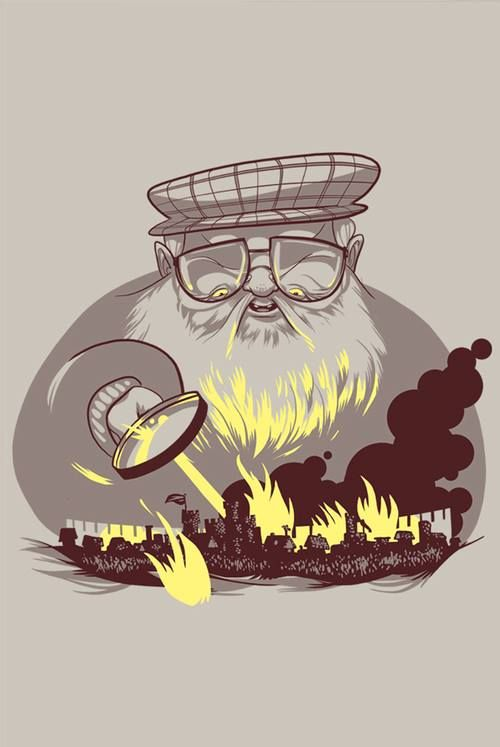

В данном задании мы будем работать с датасетом о персонажах из вселенной Игры Престолов [A Wiki of Ice and Fire](http://awoiaf.westeros.org/). Нам предстоит предсказать, кто из персонажей умрет, а кто останется вживых.



Описание данных:

* **name**: Имя персонажа

* **Title**: Социальный статус или знатность

* **House**: Дом, к которому принадлежит персонаж

* **Culture**: Социальная группа, к которой принадлежит персонаж

* **book1/2/3/4/5**: Появление персонажа в книге

* **Is noble**: Знатность персонажа, основанное на титуле

* **Age**: Отсчет времени: 305 AC

* **male**: Мужчина или женщина

* **dateOfBirth**: дата рождения

* **Spouse**: Имя супруги\а персонажа

* **Father**: Имя отца персонажа

* **Mother**: Имя матери персонажа

* **Heir**: Имя наследника персонажа

* **Is married**: Represents whether the character is married

* **Is spouse alive**: Represents whether character's spouse is alive

* **Is mother alive:** Жива ли мать персонажа

* **Is heir alive:** Жив ли наследник персонажа

* **Is father alive:** Указывает, жив ли отец персонажа

* **Number dead relations:** Количество умерших персонажей, с которыми персонаж связан

* **Popularity score:** Количество внутренних входящих и исходящих ссылок на страницу персонажей в вики http://awoiaf.westeros.org

Целевая переменная:
* **isAlive**: жив ли персонаж в книге

# Initial analysis

## Часть 1. Анализ и предобработка данных

Загружаем датасет

In [1]:
# !gdown 1h99toeF7lZ2I3iJwehgKO-QQmDaOe_O3 # test dataset
# !gdown 1XL0VTygpZj-ZAuTNRBgApZTPQyNDnT-v # train dataset

# Import libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import randint, uniform

import time
import copy
import logging
import warnings
import csv

from sklearn.exceptions import ConvergenceWarning
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.utils.validation import check_is_fitted
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C_kern, WhiteKernel
from sklearn.metrics._classification import classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier

from feature_engine.encoding import RareLabelEncoder
from category_encoders import TargetEncoder

from IPython.display import display

In [3]:
df_train = pd.read_csv('content/game_of_thrones_train.csv', index_col='S.No')
df_test = pd.read_csv('content/game_of_thrones_test.csv', index_col='S.No')

In [4]:
df_train

,name,title,male,culture,dateOfBirth,mother,father,heir,house,spouse,...,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
S.No,,,,,,,,,,,,,,,,,,,,,
1,Viserys II Targaryen,NaN,1,NaN,NaN,Rhaenyra Targaryen,Daemon Targaryen,Aegon IV Targaryen,NaN,NaN,...,1.0,0.0,0.0,NaN,0,0,NaN,11,0.605351,0
2,Walder Frey,Lord of the Crossing,1,Rivermen,208.0,NaN,NaN,NaN,House Frey,Perra Royce,...,NaN,NaN,NaN,1.0,1,1,97.0,1,0.896321,1
3,Addison Hill,Ser,1,NaN,NaN,NaN,NaN,NaN,House Swyft,NaN,...,NaN,NaN,NaN,NaN,0,1,NaN,0,0.267559,1
4,Aemma Arryn,Queen,0,NaN,82.0,NaN,NaN,NaN,House Arryn,Viserys I Targaryen,...,NaN,NaN,NaN,0.0,1,1,23.0,0,0.183946,0
5,Sylva Santagar,Greenstone,0,Dornish,276.0,NaN,NaN,NaN,House Santagar,Eldon Estermont,...,NaN,NaN,NaN,1.0,1,1,29.0,0,0.043478,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,Marwyn,Archmaester,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,1,NaN,0,0.160535,1
1554,Masha Heddle,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,0,0.040134,0
1555,Matthos Seaworth,NaN,1,NaN,NaN,NaN,NaN,NaN,House Seaworth,NaN,...,NaN,NaN,NaN,NaN,0,0,NaN,0,0.076923,0


In [5]:
df_train.columns

Index(['name', 'title', 'male', 'culture', 'dateOfBirth', 'mother', 'father',
       'heir', 'house', 'spouse', 'book1', 'book2', 'book3', 'book4', 'book5',
       'isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse',
       'isMarried', 'isNoble', 'age', 'numDeadRelations', 'popularity',
       'isAlive'],
      dtype='object')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1557 entries, 1 to 1557
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              1557 non-null   object 
 1   title             717 non-null    object 
 2   male              1557 non-null   int64  
 3   culture           488 non-null    object 
 4   dateOfBirth       279 non-null    float64
 5   mother            18 non-null     object 
 6   father            22 non-null     object 
 7   heir              21 non-null     object 
 8   house             1176 non-null   object 
 9   spouse            200 non-null    object 
 10  book1             1557 non-null   int64  
 11  book2             1557 non-null   int64  
 12  book3             1557 non-null   int64  
 13  book4             1557 non-null   int64  
 14  book5             1557 non-null   int64  
 15  isAliveMother     18 non-null     float64
 16  isAliveFather     22 non-null     float64
 17  

In [7]:
df_train.describe()

,male,dateOfBirth,book1,book2,book3,book4,book5,isAliveMother,isAliveFather,isAliveHeir,isAliveSpouse,isMarried,isNoble,age,numDeadRelations,popularity,isAlive
count,1557.000000,279.000000,1557.000000,1557.000000,1557.000000,1557.000000,1557.000000,18.000000,22.000000,21.000000,200.00000,1557.000000,1557.000000,279.000000,1557.000000,1557.000000,1557.000000
mean,0.590880,247.551971,0.138728,0.327553,0.431599,0.562620,0.330122,0.666667,0.227273,0.666667,0.79000,0.128452,0.439306,35.290323,0.187540,0.062400,0.778420
std,0.491829,61.550441,0.345774,0.469472,0.495458,0.496223,0.470408,0.485071,0.428932,0.483046,0.40833,0.334700,0.496462,26.364864,1.114648,0.121416,0.415443
min,0.000000,-25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,241.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,16.000000,0.000000,0.013378,1.000000
50%,1.000000,272.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.00000,0.000000,0.000000,24.000000,0.000000,0.023411,1.000000
75%,1.000000,286.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.00000,0.000000,1.000000,49.000000,0.000000,0.063545,1.000000
max,1.000000,299.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,100.000000,15.000000,1.000000,1.000000


Предобработка (очистка) данных

In [8]:
# amount of NaN in every column
NaN_amount_col = df_train.isna().sum(axis=0)
NaN_amount_col

name                   0
title                840
male                   0
culture             1069
dateOfBirth         1278
mother              1539
father              1535
heir                1536
house                381
spouse              1357
book1                  0
book2                  0
book3                  0
book4                  0
book5                  0
isAliveMother       1539
isAliveFather       1535
isAliveHeir         1536
isAliveSpouse       1357
isMarried              0
isNoble                0
age                 1278
numDeadRelations       0
popularity             0
isAlive                0
dtype: int64

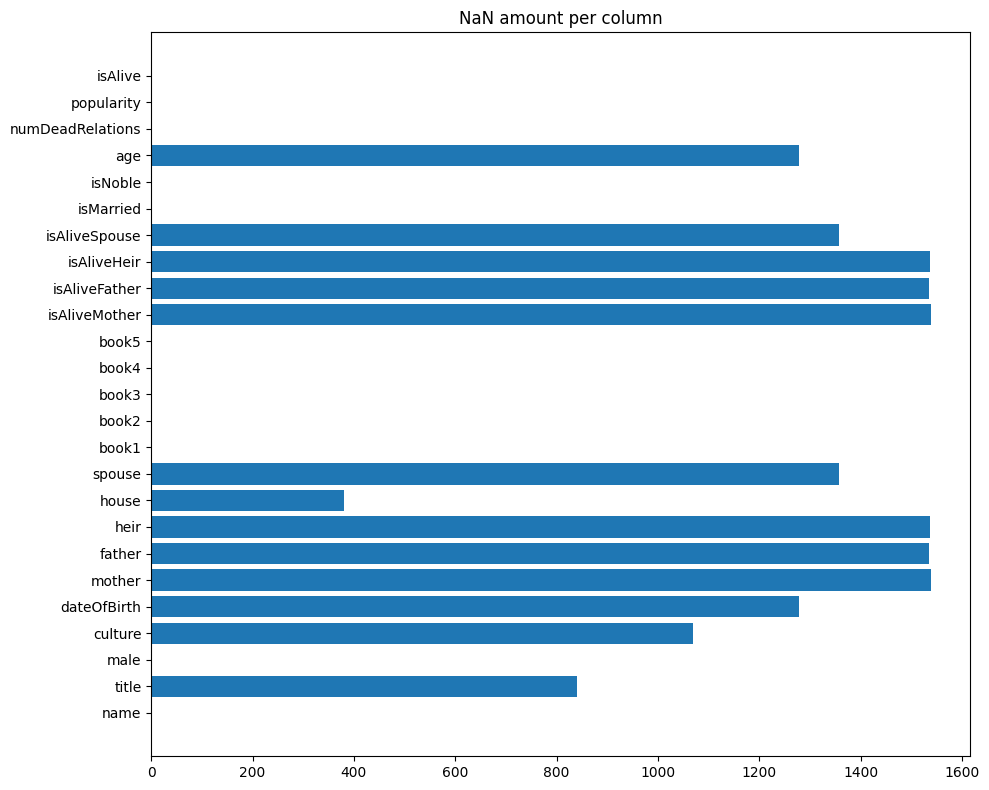

In [9]:
plt.figure(figsize=(10, 8)) 
plt.barh(NaN_amount_col.index, NaN_amount_col.values)
plt.title('NaN amount per column')
plt.tight_layout()
plt.show()

In [10]:
# amount of NaN in every row (with names)
row_NaN = df_train.isna().sum(axis=1)
name_to_NaN_df = pd.DataFrame({'name': df_train['name'], 'NaN amount': row_NaN})
name_to_NaN_df

,name,NaN amount
S.No,,
1,Viserys II Targaryen,7
2,Walder Frey,6
3,Addison Hill,11
4,Aemma Arryn,7
5,Sylva Santagar,6
...,...,...
1553,Marwyn,12
1554,Masha Heddle,13
1555,Matthos Seaworth,12


In [11]:
# top 5 elements with highest amount of NaN
name_to_NaN_df.sort_values(by='NaN amount').iloc[-6:-1]

,name,NaN amount
S.No,,
110,Roger of Pennytree,13
794,Mudge (miller),13
103,Robin,13
546,Green Gergen,13
567,Gyles III Gardener,13


In [12]:
# check types
n = len(df_train)
NaN_analysis_col_df = pd.DataFrame({'column' : df_train.dtypes.index, 
                                    'NaN amount': NaN_amount_col.values, 
                                    '%': NaN_amount_col.values / n * 100,
                                    'dtype': df_train.dtypes.values})

NaN_analysis_col_clear_df = NaN_analysis_col_df.loc[(NaN_analysis_col_df['NaN amount'] != 0)]
NaN_analysis_col_clear_df

,column,NaN amount,%,dtype
1,title,840,53.949904,object
3,culture,1069,68.657675,object
4,dateOfBirth,1278,82.080925,float64
5,mother,1539,98.843931,object
6,father,1535,98.587026,object
7,heir,1536,98.651252,object
8,house,381,24.470135,object
9,spouse,1357,87.154785,object
15,isAliveMother,1539,98.843931,float64
16,isAliveFather,1535,98.587026,float64


In [13]:
# extract only categorical data
NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df.dtype == 'object')]

,column,NaN amount,%,dtype
1,title,840,53.949904,object
3,culture,1069,68.657675,object
5,mother,1539,98.843931,object
6,father,1535,98.587026,object
7,heir,1536,98.651252,object
8,house,381,24.470135,object
9,spouse,1357,87.154785,object


In [14]:
# extract column names with data of type 'object' (categorical)
categorical_column_names = NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df.dtype == 'object')].column.tolist()
categorical_column_names

['title', 'culture', 'mother', 'father', 'heir', 'house', 'spouse']

In [15]:
# extract only numerical data
NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df.dtype == 'float64')]

,column,NaN amount,%,dtype
4,dateOfBirth,1278,82.080925,float64
15,isAliveMother,1539,98.843931,float64
16,isAliveFather,1535,98.587026,float64
17,isAliveHeir,1536,98.651252,float64
18,isAliveSpouse,1357,87.154785,float64
21,age,1278,82.080925,float64


In [16]:
# extract column names with data of type 'float64' (numerical)
numerical_column_names = NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df.dtype == 'float64')].column.tolist()
numerical_column_names

['dateOfBirth',
 'isAliveMother',
 'isAliveFather',
 'isAliveHeir',
 'isAliveSpouse',
 'age']

In [17]:
# Заполним (или удалим) пропущенные значения
# Числовые - медианой
# Категориальные - модой

# maybe delete: 
# maybe delete: dateOfBirth, age

# columns with high percentage of NaN elements (>80%) 
high_NaN_cat_columns = NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df['%'] >= 85) & (NaN_analysis_col_clear_df.dtype == 'object')]['column'].tolist()
high_NaN_num_columns = NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df['%'] >= 85) & (NaN_analysis_col_clear_df.dtype == 'float64')]['column'].tolist()

print(high_NaN_cat_columns)
print(high_NaN_num_columns)

# divide df into two: with numerical and categorical data
df_train_categorical = df_train[categorical_column_names].drop(columns=
    high_NaN_cat_columns
)  # too many NaN elements

df_train_numerical = df_train[numerical_column_names].drop(columns=
    high_NaN_num_columns
)  # too many NaN elements

# remember the rest of the data (already clean)
df_train_rest = df_train[list(
    set(df_train.columns.tolist()) - \
    set(categorical_column_names + numerical_column_names)
)]

['mother', 'father', 'heir', 'spouse']
['isAliveMother', 'isAliveFather', 'isAliveHeir', 'isAliveSpouse']


In [18]:
df_train_categorical

,title,culture,house
S.No,,,
1,NaN,NaN,NaN
2,Lord of the Crossing,Rivermen,House Frey
3,Ser,NaN,House Swyft
4,Queen,NaN,House Arryn
5,Greenstone,Dornish,House Santagar
...,...,...,...
1553,Archmaester,NaN,NaN
1554,NaN,NaN,NaN
1555,NaN,NaN,House Seaworth


In [19]:
# clean categorical data
df_train_categorical_clean = df_train_categorical.fillna(df_train_categorical.mode().iloc[0])
df_train_categorical_clean

,title,culture,house
S.No,,,
1,Ser,Northmen,House Frey
2,Lord of the Crossing,Rivermen,House Frey
3,Ser,Northmen,House Swyft
4,Queen,Northmen,House Arryn
5,Greenstone,Dornish,House Santagar
...,...,...,...
1553,Archmaester,Northmen,House Frey
1554,Ser,Northmen,House Frey
1555,Ser,Northmen,House Seaworth


In [20]:
df_train_numerical

,dateOfBirth,age
S.No,,
1,NaN,NaN
2,208.0,97.0
3,NaN,NaN
4,82.0,23.0
5,276.0,29.0
...,...,...
1553,NaN,NaN
1554,NaN,NaN
1555,NaN,NaN


In [21]:
# clean numerical data
df_train_numerical_clean = df_train_numerical.fillna(df_train_numerical.median())
df_train_numerical_clean

,dateOfBirth,age
S.No,,
1,272.0,24.0
2,208.0,97.0
3,272.0,24.0
4,82.0,23.0
5,276.0,29.0
...,...,...
1553,272.0,24.0
1554,272.0,24.0
1555,272.0,24.0


In [22]:
df_train_rest

,male,isNoble,name,book2,book1,isMarried,book5,isAlive,book4,book3,numDeadRelations,popularity
S.No,,,,,,,,,,,,
1,1,0,Viserys II Targaryen,0,0,0,0,0,0,0,11,0.605351
2,1,1,Walder Frey,1,1,1,1,1,1,1,1,0.896321
3,1,1,Addison Hill,0,0,0,0,1,1,0,0,0.267559
4,0,1,Aemma Arryn,0,0,1,0,0,0,0,0,0.183946
5,0,1,Sylva Santagar,0,0,1,0,1,1,0,0,0.043478
...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1,1,Marwyn,0,1,0,0,1,1,1,0,0.160535
1554,0,0,Masha Heddle,1,1,0,0,0,0,0,0,0.040134
1555,1,0,Matthos Seaworth,1,0,0,1,0,1,1,0,0.076923


In [23]:
# combine cleaned data
df_train_clean = pd.concat([df_train_rest, df_train_categorical_clean, df_train_numerical_clean],axis=1)
df_train_clean

,male,isNoble,name,book2,book1,isMarried,book5,isAlive,book4,book3,numDeadRelations,popularity,title,culture,house,dateOfBirth,age
S.No,,,,,,,,,,,,,,,,,
1,1,0,Viserys II Targaryen,0,0,0,0,0,0,0,11,0.605351,Ser,Northmen,House Frey,272.0,24.0
2,1,1,Walder Frey,1,1,1,1,1,1,1,1,0.896321,Lord of the Crossing,Rivermen,House Frey,208.0,97.0
3,1,1,Addison Hill,0,0,0,0,1,1,0,0,0.267559,Ser,Northmen,House Swyft,272.0,24.0
4,0,1,Aemma Arryn,0,0,1,0,0,0,0,0,0.183946,Queen,Northmen,House Arryn,82.0,23.0
5,0,1,Sylva Santagar,0,0,1,0,1,1,0,0,0.043478,Greenstone,Dornish,House Santagar,276.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1,1,Marwyn,0,1,0,0,1,1,1,0,0.160535,Archmaester,Northmen,House Frey,272.0,24.0
1554,0,0,Masha Heddle,1,1,0,0,0,0,0,0,0.040134,Ser,Northmen,House Frey,272.0,24.0
1555,1,0,Matthos Seaworth,1,0,0,1,0,1,1,0,0.076923,Ser,Northmen,House Seaworth,272.0,24.0


In [24]:
df_train_clean.isna().sum()

male                0
isNoble             0
name                0
book2               0
book1               0
isMarried           0
book5               0
isAlive             0
book4               0
book3               0
numDeadRelations    0
popularity          0
title               0
culture             0
house               0
dateOfBirth         0
age                 0
dtype: int64

In [25]:
# also clean test data

high_NaN_cat_columns = NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df['%'] >= 85) & (NaN_analysis_col_clear_df.dtype == 'object')]['column'].tolist()
high_NaN_num_columns = NaN_analysis_col_clear_df.loc[(NaN_analysis_col_clear_df['%'] >= 85) & (NaN_analysis_col_clear_df.dtype == 'float64')]['column'].tolist()

# divide df into two: with numerical and categorical data
df_test_categorical = df_test[categorical_column_names].drop(columns=
    high_NaN_cat_columns
)  # too many NaN elements

df_test_numerical = df_test[numerical_column_names].drop(columns=
    high_NaN_num_columns
)  # too many NaN elements

# remember the rest of the data (already clean)
df_test_rest = df_test[list(
    set(df_test.columns.tolist()) - \
    set(categorical_column_names + numerical_column_names)
)]

# clean data
df_test_categorical_clean = df_test_categorical.fillna(df_train_categorical.mode().iloc[0])  # train.mode() !
dt_test_numerical_clean = df_test_numerical.fillna(df_train_numerical.median())  # train.median() !

# combine cleaned data
df_test_clean = pd.concat([df_test_rest, df_test_categorical_clean, dt_test_numerical_clean],axis=1)
df_test_clean


,male,isNoble,name,book2,book1,isMarried,book5,book4,book3,numDeadRelations,popularity,title,culture,house,dateOfBirth,age
S.No,,,,,,,,,,,,,,,,
1558,0,0,Melissa Blackwood,0,0,0,1,0,0,0,0.050167,Ser,Northmen,House Blackwood,156.0,100.0
1559,0,0,Melisandre,1,0,0,1,1,1,0,0.745819,Ser,Asshai,R'hllor,272.0,24.0
1560,0,0,Merrit,0,0,0,0,1,1,0,0.010033,Ser,Northmen,Brotherhood without banners,272.0,24.0
1561,1,1,Meryn Trant,1,1,0,1,1,1,0,0.220736,Ser,Northmen,House Trant,272.0,24.0
1562,1,0,Merrett Frey,1,1,1,1,1,1,0,0.434783,Ser,Riverlands,House Frey,262.0,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1942,1,0,Luwin,1,1,0,1,1,1,0,0.351171,Ser,Westeros,House Stark,272.0,24.0
1943,1,0,Reek,1,0,0,1,1,0,0,0.096990,Ser,Northmen,House Bolton,272.0,24.0
1944,1,0,Symeon Star-Eyes,1,1,0,1,1,1,0,0.030100,Ser,Northmen,House Frey,272.0,24.0


In [26]:
df_test_clean.isna().sum()

male                0
isNoble             0
name                0
book2               0
book1               0
isMarried           0
book5               0
book4               0
book3               0
numDeadRelations    0
popularity          0
title               0
culture             0
house               0
dateOfBirth         0
age                 0
dtype: int64

Создадим новые признаки

In [27]:
# create isPopular
threshold = 0.5
df_train_clean['popularity'] = (df_train_clean['popularity'] >= threshold).astype(int)
df_train_clean = df_train_clean.rename(columns={'popularity': 'isPopular'})
df_train_clean['isPopular']

S.No
1       1
2       1
3       0
4       0
5       0
       ..
1553    0
1554    0
1555    0
1556    0
1557    0
Name: isPopular, Length: 1557, dtype: int64

In [28]:
# create boolDeadRelations
df_train_clean['numDeadRelations'] = (df_train_clean['numDeadRelations'] > 0).astype(int)
df_train_clean.rename(columns={'numDeadRelations': 'boolDeadRelations'}, inplace=True)
df_train_clean

,male,isNoble,name,book2,book1,isMarried,book5,isAlive,book4,book3,boolDeadRelations,isPopular,title,culture,house,dateOfBirth,age
S.No,,,,,,,,,,,,,,,,,
1,1,0,Viserys II Targaryen,0,0,0,0,0,0,0,1,1,Ser,Northmen,House Frey,272.0,24.0
2,1,1,Walder Frey,1,1,1,1,1,1,1,1,1,Lord of the Crossing,Rivermen,House Frey,208.0,97.0
3,1,1,Addison Hill,0,0,0,0,1,1,0,0,0,Ser,Northmen,House Swyft,272.0,24.0
4,0,1,Aemma Arryn,0,0,1,0,0,0,0,0,0,Queen,Northmen,House Arryn,82.0,23.0
5,0,1,Sylva Santagar,0,0,1,0,1,1,0,0,0,Greenstone,Dornish,House Santagar,276.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1,1,Marwyn,0,1,0,0,1,1,1,0,0,Archmaester,Northmen,House Frey,272.0,24.0
1554,0,0,Masha Heddle,1,1,0,0,0,0,0,0,0,Ser,Northmen,House Frey,272.0,24.0
1555,1,0,Matthos Seaworth,1,0,0,1,0,1,1,0,0,Ser,Northmen,House Seaworth,272.0,24.0


In [29]:
# simplify culture
cultures = df_train_clean['culture'].unique()

# lower culture names
for culture in cultures:
    df_train_clean.replace({'culture': culture}, 
                           culture.lower(), 
                           inplace=True)

# print the results
cultures = sorted(df_train_clean['culture'].unique())
for ind, culture in enumerate(cultures):
    print(f'{culture:<25}', end=' ')
    if (ind+1) % 5 == 0:
        print()

andal                     andals                    astapori                  braavos                   braavosi                  
crannogmen                dorne                     dornish                   dornishmen                dothraki                  
first men                 free folk                 ghiscari                  ghiscaricari              ironborn                  
ironmen                   lhazareen                 lhazarene                 lysene                    lyseni                    
meereenese                myrish                    northern mountain clans   northmen                  norvoshi                  
pentoshi                  qarth                     qartheen                  qohor                     reach                     
rivermen                  sistermen                 stormlands                summer islander           summer islands            
summer isles              tyroshi                   vale                      vale 

In [30]:
cult = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

for replacement, what_to_replace in cult.items():
    replacement = replacement.lower()
    if type(what_to_replace) == list:
        for el in what_to_replace:
            df_train_clean.replace({'culture': el}, 
                                   replacement, inplace=True)
    else:
        df_train_clean.replace({'culture': what_to_replace}, 
                               replacement, inplace=True)

# print the results
cultures = sorted(df_train_clean['culture'].unique())
for ind, culture in enumerate(cultures):
    print(f'{culture:<25}', end=' ')
    if (ind+1) % 5 == 0:
        print()

andal                     astapori                  braavosi                  crannogmen                dornish                   
dothraki                  free folk                 ghiscari                  ironborn                  ironmen                   
lhazareen                 lhazarene                 lysene                    meereenese                myrish                    
northern mountain clans   northmen                  norvoshi                  pentoshi                  qartheen                  
qohor                     reach                     rivermen                  sistermen                 stormlander               
summer islands            tyroshi                   vale                      vale mountain clans       valemen                   
valyrian                  westermen                 westerosi                 

In [31]:
# perform the same actions with test data

# create isPopular
threshold = 0.5
df_test_clean['popularity'] = (df_test_clean['popularity'] >= threshold).astype(int)
df_test_clean = df_test_clean.rename(columns={'popularity': 'isPopular'})

# create boolDeadRelations
df_test_clean['numDeadRelations'] = (df_test_clean['numDeadRelations'] > 0).astype(int)
df_test_clean.rename(columns={'numDeadRelations': 'boolDeadRelations'}, inplace=True)

# simplify culture
cultures = df_test_clean['culture'].unique()

for culture in cultures:
    df_test_clean.replace({'culture': culture}, 
                          culture.lower(), 
                          inplace=True)

for replacement, what_to_replace in cult.items():
    replacement = replacement.lower()
    if type(what_to_replace) == list:
        for el in what_to_replace:
            df_test_clean.replace({'culture': el}, 
                                  replacement, inplace=True)
    else:
        df_test_clean.replace({'culture': what_to_replace}, 
                              replacement, inplace=True)
        
# print the results
cultures = sorted(df_test_clean['culture'].unique())
for ind, culture in enumerate(cultures):
    print(f'{culture:<25}', end=' ')
    if (ind+1) % 5 == 0:
        print()

asshai                    astapor                   braavosi                  crannogmen                dornish                   
dothraki                  free folk                 ghiscari                  ibbenese                  ironborn                  
ironmen                   lhazareen                 lysene                    meereen                   meereenese                
myrish                    naathi                    northern mountain clans   northmen                  norvoshi                  
pentoshi                  qartheen                  qohor                     reach                     rhoynar                   
riverlands                rivermen                  stormlander               summer islands            tyroshi                   
vale mountain clans       valemen                   valyrian                  westermen                 westerosi                 
wildlings                 

Удалите ненужные столбцы

In [32]:
# dateOfBirth == age
uninformative = ['name', 'dateOfBirth']

df_train_clean.columns

Index(['male', 'isNoble', 'name', 'book2', 'book1', 'isMarried', 'book5',
       'isAlive', 'book4', 'book3', 'boolDeadRelations', 'isPopular', 'title',
       'culture', 'house', 'dateOfBirth', 'age'],
      dtype='object')

In [33]:
df_train_clean.drop(columns=uninformative, inplace = True)
df_test_clean.drop(columns=uninformative, inplace = True)
df_train_clean

,male,isNoble,book2,book1,isMarried,book5,isAlive,book4,book3,boolDeadRelations,isPopular,title,culture,house,age
S.No,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,1,1,Ser,northmen,House Frey,24.0
2,1,1,1,1,1,1,1,1,1,1,1,Lord of the Crossing,rivermen,House Frey,97.0
3,1,1,0,0,0,0,1,1,0,0,0,Ser,northmen,House Swyft,24.0
4,0,1,0,0,1,0,0,0,0,0,0,Queen,northmen,House Arryn,23.0
5,0,1,0,0,1,0,1,1,0,0,0,Greenstone,dornish,House Santagar,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1,1,0,1,0,0,1,1,1,0,0,Archmaester,northmen,House Frey,24.0
1554,0,0,1,1,0,0,0,0,0,0,0,Ser,northmen,House Frey,24.0
1555,1,0,1,0,0,1,0,1,1,0,0,Ser,northmen,House Seaworth,24.0


Проанализируем целевую переменную.

In [34]:
df_train_clean_backup = copy.deepcopy(df_train_clean)

In [35]:
size = len(df_train_clean)
alive = df_train_clean['isAlive'].sum()
dead = size - alive

print(f'alive: {alive/size * 100}%, dead: {dead/size * 100}%')
print(f'there are {alive/dead} times more alive people than dead')
# dataset is significantly imbalanced

alive: 77.84200385356455%, dead: 22.15799614643545%
there are 3.5130434782608697 times more alive people than dead


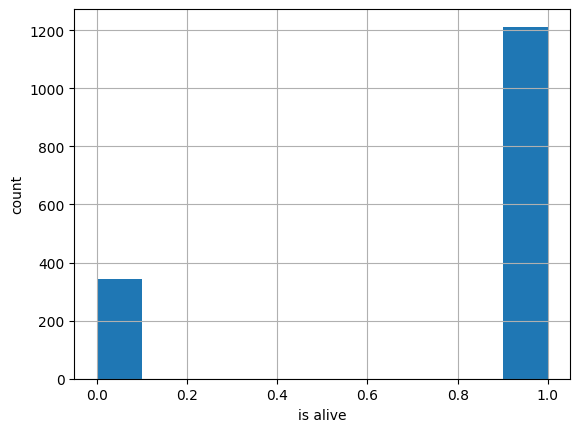

In [36]:
plt.figure()

df_train_clean['isAlive'].hist()
plt.xlabel('is alive')
plt.ylabel('count')

plt.show()

isAlive
1    1212
0     345
Name: count, dtype: int64


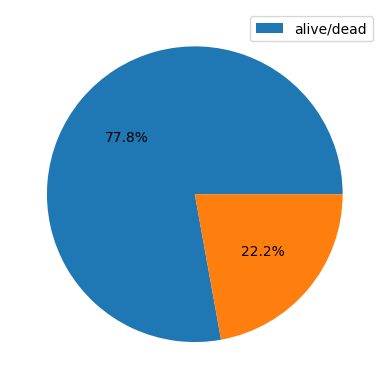

In [37]:
plt.figure()

data = df_train_clean['isAlive'].value_counts()
print(data)
plt.pie(data, autopct='%1.1f%%')

plt.legend(['alive/dead'])
plt.show()

Проанализируем признаки

In [38]:
print(df_train_clean.columns)
print(f'titles(n={len(df_train_clean['title'].unique())}): {df_train_clean['title'].unique().tolist()}')
print(f'cultures(n={len(df_train_clean['culture'].unique())}): {df_train_clean['culture'].unique().tolist()}')
print(f'houses(n={len(df_train_clean['house'].unique())}): {df_train_clean['house'].unique().tolist()}')
df_train_clean

# onehot encoding (with bin rare(reduce cardinality)) ?
# target encoding (with regularization) ? + bin rare
# frequency encoding ?

# binary encoding + frequency encoding with bin rare (would be better for linear models)
# for deceision tree it is better to use target encoding with regularization

Index(['male', 'isNoble', 'book2', 'book1', 'isMarried', 'book5', 'isAlive',
       'book4', 'book3', 'boolDeadRelations', 'isPopular', 'title', 'culture',
       'house', 'age'],
      dtype='object')
titles(n=195): ['Ser', 'Lord of the Crossing', 'Queen', 'Greenstone', 'Hand of the King', 'Archmaester', 'Maester', 'Khal', 'red hand', 'Castellan', 'Seven Kingdoms', 'PrincessQueen', 'Lord of the Iron Islands', 'Lord', 'Brother', 'Lord of Coldmoat', 'Prince of Dragonstone', 'Lady', 'PrincessSepta', 'Princess', 'Septa', 'Grand Maester', 'Septon', 'King', 'Seneschal', 'Bloodrider', 'Stokeworth', 'Prince', 'LadyQueenDowager Queen', 'Lord of the Tides', 'Lord of Dragonstone', 'Goodman', 'Wisdom', 'King in the North', 'Winterfell', 'Steward', 'Eyrie', 'Casterly Rock', 'Cupbearer', 'Hornwood', 'Lord Steward of the Iron Islands', 'Blue Grace', 'Red Priest', 'Khalakka', 'Good Master', 'QueenBlack Bride', 'Last Hearth', 'Lord Paramount of the Mander', 'Seagard', 'Goodwife', 'Uplands', 'BrotherPr

,male,isNoble,book2,book1,isMarried,book5,isAlive,book4,book3,boolDeadRelations,isPopular,title,culture,house,age
S.No,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,1,1,Ser,northmen,House Frey,24.0
2,1,1,1,1,1,1,1,1,1,1,1,Lord of the Crossing,rivermen,House Frey,97.0
3,1,1,0,0,0,0,1,1,0,0,0,Ser,northmen,House Swyft,24.0
4,0,1,0,0,1,0,0,0,0,0,0,Queen,northmen,House Arryn,23.0
5,0,1,0,0,1,0,1,1,0,0,0,Greenstone,dornish,House Santagar,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1,1,0,1,0,0,1,1,1,0,0,Archmaester,northmen,House Frey,24.0
1554,0,0,1,1,0,0,0,0,0,0,0,Ser,northmen,House Frey,24.0
1555,1,0,1,0,0,1,0,1,1,0,0,Ser,northmen,House Seaworth,24.0


title
Ser                     1146
Maester                   29
Archmaester               21
Lord                      19
Septon                    16
                        ... 
Lord of Greyshield         1
Lord of the Crossing       1
Felwood                    1
Goldgrass                  1
Highgarden                 1
Name: count, Length: 195, dtype: int64


([], [])

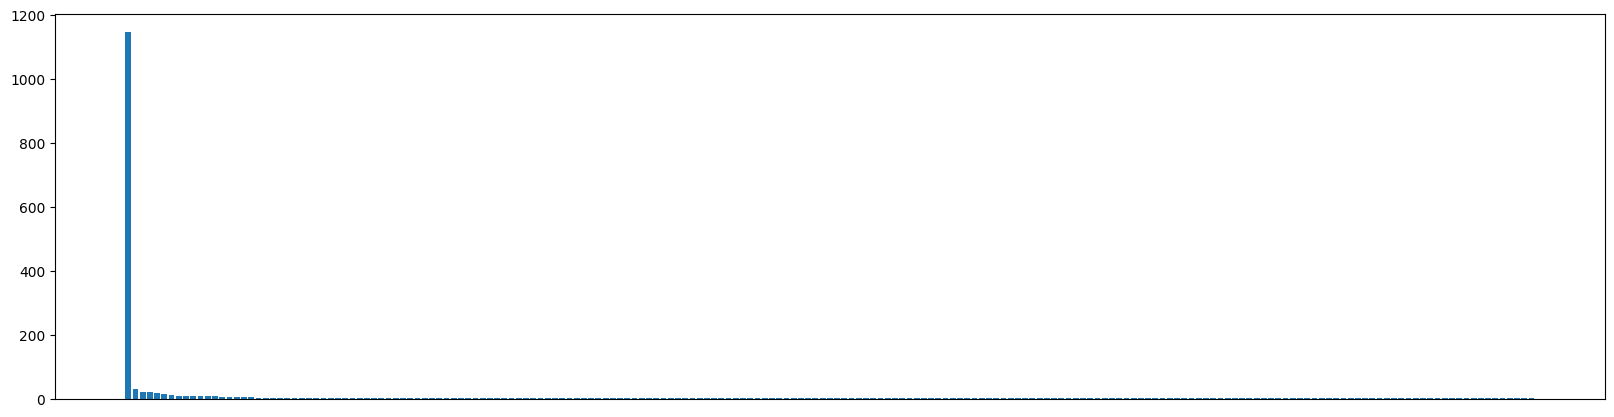

In [39]:
# count unique title occurrences 
title_occurrences = df_train_clean['title'].value_counts()
print(title_occurrences)  # the idea behind frequency encoding (+normalization needed)

plt.figure(figsize=(20,5))
plt.bar(title_occurrences.index, title_occurrences.values)
plt.xticks([])

In [40]:
# count the percentage of each occurrence
n = len(df_train_clean['title'])
pd.DataFrame({
    'title': title_occurrences.index,
    'occurrence': title_occurrences.values,
    '%': title_occurrences.values / n * 100
})

,title,occurrence,%
0,Ser,1146,73.603083
1,Maester,29,1.862556
2,Archmaester,21,1.348748
3,Lord,19,1.220295
4,Septon,16,1.027617
...,...,...,...
190,Lord of Greyshield,1,0.064226
191,Lord of the Crossing,1,0.064226
192,Felwood,1,0.064226
193,Goldgrass,1,0.064226


In [41]:
df_train_clean[['title', 'isAlive']].groupby(['title'], as_index=False).mean()  # the idea behind target encoding

,title,isAlive
0,Acorn Hall,1.0
1,Archmaester,1.0
2,Ashford,1.0
3,Banefort,1.0
4,Big BucketThe Wull,1.0
...,...,...
190,Wraith,0.0
191,Wyndhall,1.0
192,Yronwood,1.0
193,master of ships,1.0


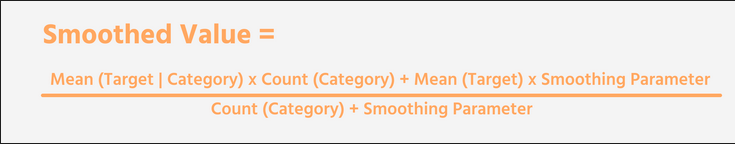

In [42]:
# perform target encoding with smoothing regularization and bin rare
def target_encode(df_train, column_name,
                            target_name,
                            bin_rare_threshold,
                            bayesian_smoothing_alpha,
                            df_test = None):

    # bin rare (preparartion) 
    value_occurrences = df_train[column_name].value_counts()
    rare_categories = value_occurrences[value_occurrences <= bin_rare_threshold].index.tolist()
    rare_placeholder = f'Rare_{column_name}'
    
    # create copies
    df_train_encoded = copy.deepcopy(df_train)
    if df_test is not None:
        df_test_encoded = copy.deepcopy(df_test)
    else:
        df_test_encoded = None

    # perform bin rare
    df_train_encoded.replace({column_name: rare_categories}, rare_placeholder, inplace=True)
    if df_test is not None:
        df_test_encoded.replace({column_name: rare_categories}, rare_placeholder, inplace=True)

    # calculate smoothing map for target encoding
    target_mean = df_train_encoded[target_name].mean()  # global target mean
    n  = df_train_encoded.groupby(column_name).size()  # count unique occurrences
    mu = df_train_encoded.groupby(column_name)[target_name].mean()  # individual title target means

    smoothing = (mu * n + target_mean * bayesian_smoothing_alpha)/(n + bayesian_smoothing_alpha)  # classic Bayes regularization

    # perform target encoding
    df_train_encoded[column_name] = df_train_encoded[column_name].map(smoothing)
    if df_test is not None:
        df_test_encoded[column_name] = df_test_encoded[column_name].map(smoothing)
        
        # fill NaNs
        df_test_encoded.fillna({column_name: target_mean}, inplace=True)

    return df_train_encoded, df_test_encoded

In [43]:
# apply target encoding to the title column 
df_train_clean, df_test_clean = target_encode(df_train=df_train_clean, 
                                              column_name='title',
                                              target_name='isAlive',
                                              bin_rare_threshold=2,  # check with cv fold 
                                              bayesian_smoothing_alpha=5,  # check with cv fold 
                                              df_test=df_test_clean)
df_train_clean['title']

S.No
1       0.793130
2       0.754552
3       0.793130
4       0.486513
5       0.754552
          ...   
1553    0.957388
1554    0.793130
1555    0.793130
1556    0.793130
1557    0.793130
Name: title, Length: 1557, dtype: float64

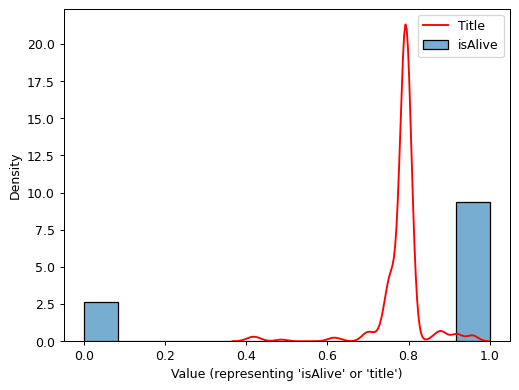

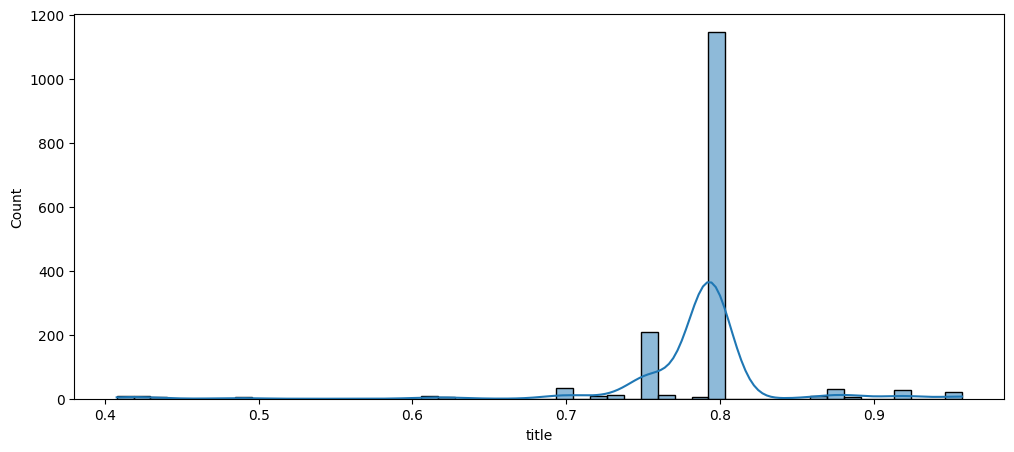

In [44]:
# plot the results

# first combined plot
plt.figure(dpi=90)
ax = sns.histplot(data=df_train_clean, x='isAlive', stat='density', kde=False, label='isAlive', alpha=0.6)
sns.kdeplot(data=df_train_clean, x='title', color='r', ax=ax, label='Title')
ax.set_xlabel("Value (representing 'isAlive' or 'title')")
ax.set_ylabel("Density")
ax.legend()
plt.show()

# second combined plot
plt.figure(figsize=(12,5))
sns.histplot(df_train_clean['title'], bins=50, kde=True)  # После кодирования
plt.show()

culture
northmen                   1172
ironborn                     92
free folk                    56
braavosi                     40
valyrian                     28
dornish                      21
ghiscari                     18
dothraki                     17
westermen                    14
reach                        13
vale mountain clans          12
valemen                      10
rivermen                     10
summer islands                6
tyroshi                       6
qartheen                      6
astapori                      4
stormlander                   4
northern mountain clans       3
lysene                        3
westerosi                     3
ironmen                       3
meereenese                    2
andal                         2
myrish                        2
sistermen                     2
crannogmen                    2
norvoshi                      1
qohor                         1
lhazareen                     1
lhazarene                     1


<BarContainer object of 33 artists>

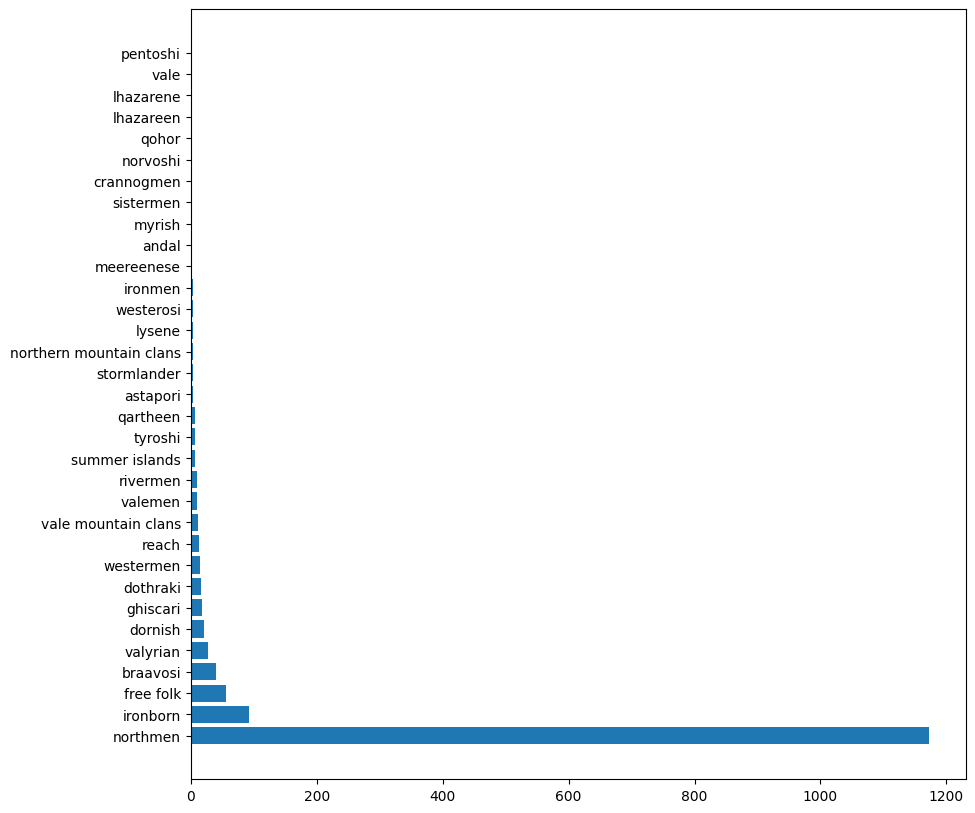

In [45]:
# count unique culture occurrences 
culture_occurrences = df_train_clean['culture'].value_counts()
print(culture_occurrences)  # the idea behind frequency encoding (+normalization needed)

plt.figure(figsize=(10,10))
plt.barh(culture_occurrences.index, culture_occurrences.values)

In [46]:
# apply target encoding to the culture column 
df_train_clean, df_test_clean = target_encode(df_train=df_train_clean, 
                                              column_name='culture',
                                              target_name='isAlive',
                                              bin_rare_threshold=2,  # check with cv fold 
                                              bayesian_smoothing_alpha=5,  # check with cv fold 
                                              df_test=df_test_clean)
df_train_clean['culture']

S.No
1       0.780707
2       0.726140
3       0.780707
4       0.780707
5       0.918927
          ...   
1553    0.780707
1554    0.780707
1555    0.780707
1556    0.661529
1557    0.780707
Name: culture, Length: 1557, dtype: float64

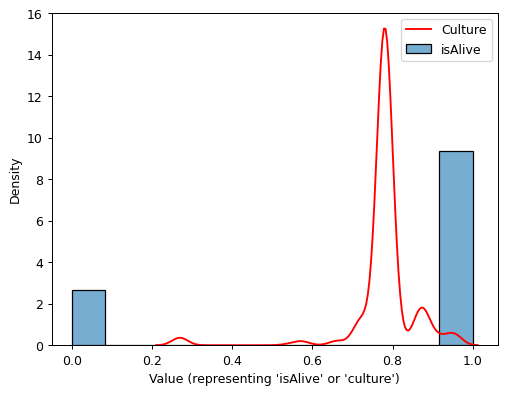

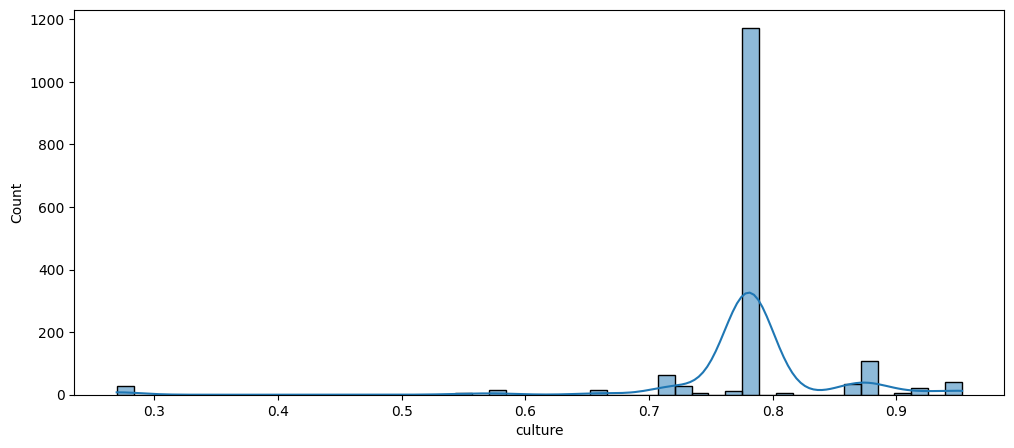

In [47]:
# plot the results

# first combined plot
plt.figure(dpi=90)
ax = sns.histplot(data=df_train_clean, x='isAlive', stat='density', kde=False, label='isAlive', alpha=0.6)
sns.kdeplot(data=df_train_clean, x='culture', color='r', ax=ax, label='Culture')
ax.set_xlabel("Value (representing 'isAlive' or 'culture')")
ax.set_ylabel("Density")
ax.legend()
plt.show()

# second combined plot
plt.figure(figsize=(12,5))
sns.histplot(df_train_clean['culture'], bins=50, kde=True)  # После кодирования
plt.show()

house
House Frey          470
Night's Watch        88
House Stark          56
House Targaryen      40
House Lannister      36
                   ... 
House Celtigar        1
House of Ghazeen      1
House Byrch           1
House Hawick          1
House Moore           1
Name: count, Length: 315, dtype: int64


([], [])

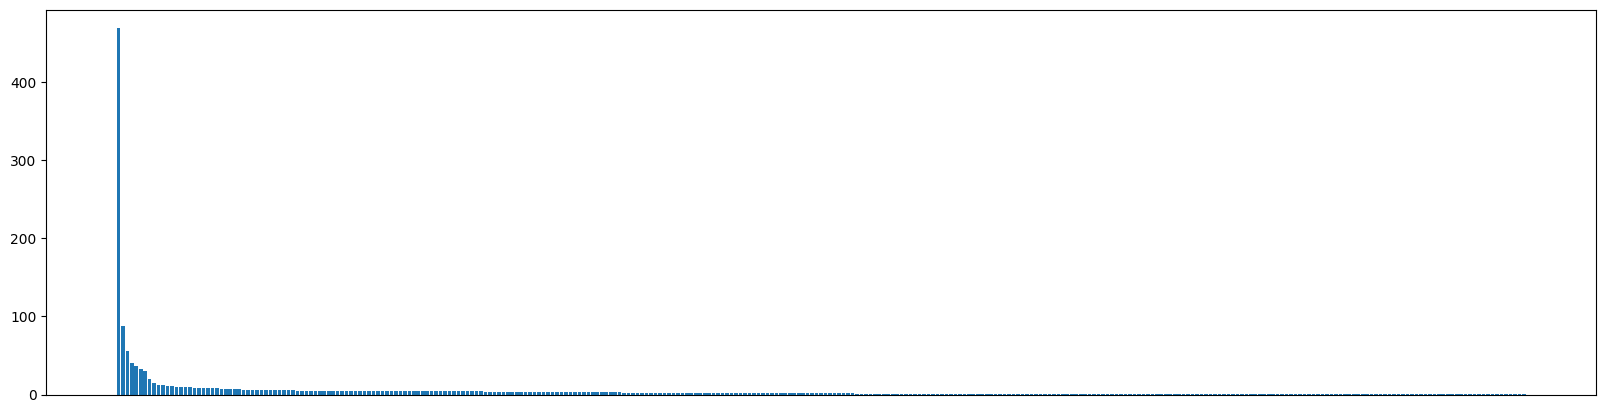

In [48]:
# count unique house occurrences 
house_occurrences = df_train_clean['house'].value_counts()
print(house_occurrences)  # the idea behind frequency encoding (+normalization needed)

plt.figure(figsize=(20,5))
plt.bar(house_occurrences.index, house_occurrences.values)
plt.xticks([])

In [49]:
# apply target encoding to the house column 
df_train_clean, df_test_clean = target_encode(df_train=df_train_clean, 
                                              column_name='house',
                                              target_name='isAlive',
                                              bin_rare_threshold=2,  # check with cv fold 
                                              bayesian_smoothing_alpha=5,  # check with cv fold 
                                              df_test=df_test_clean)
df_train_clean['house']

S.No
1       0.820825
2       0.820825
3       0.907675
4       0.680756
5       0.814255
          ...   
1553    0.820825
1554    0.820825
1555    0.574342
1556    0.814255
1557    0.814255
Name: house, Length: 1557, dtype: float64

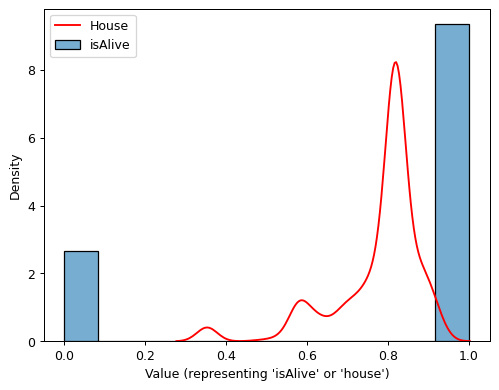

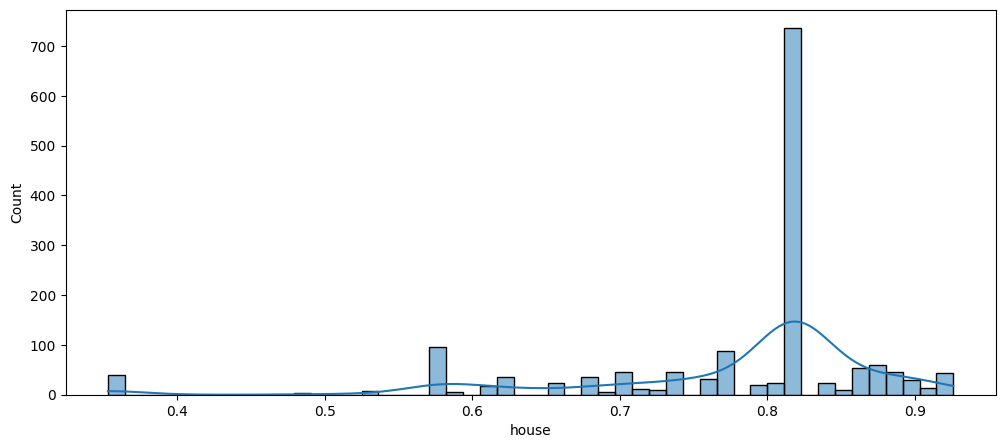

In [50]:
# plot the results

# first combined plot
plt.figure(dpi=90)
ax = sns.histplot(data=df_train_clean, x='isAlive', stat='density', kde=False, label='isAlive', alpha=0.6)
sns.kdeplot(data=df_train_clean, x='house', color='r', ax=ax, label='House')
ax.set_xlabel("Value (representing 'isAlive' or 'house')")
ax.set_ylabel("Density")
ax.legend()
plt.show()

# second combined plot
plt.figure(figsize=(12,5))
sns.histplot(df_train_clean['house'], bins=50, kde=True)  # После кодирования
plt.show()

In [51]:
# scale age (not needed for a tree model)

# normalization [0, 1]
# age_min = df_train_clean['age'].min()
# age_max = df_train_clean['age'].max()
# df_train_clean['age'] = (df_train_clean['age'] - age_min)/(age_max - age_min)

# standardization
# age_mean = df_train_clean['age'].mean()
# age_std = df_train_clean['age'].std()
# df_train_clean['age'] = (df_train_clean['age']  - age_mean)/age_std

Проанализируем влияние признаков на целевую переменную

In [52]:
# how does popularity influence being alive
# how does presence of dead realatives influence being alive
# compare males with females
# look at age
# look at encoded categories

In [53]:
df_train_clean

,male,isNoble,book2,book1,isMarried,book5,isAlive,book4,book3,boolDeadRelations,isPopular,title,culture,house,age
S.No,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,1,1,0.793130,0.780707,0.820825,24.0
2,1,1,1,1,1,1,1,1,1,1,1,0.754552,0.726140,0.820825,97.0
3,1,1,0,0,0,0,1,1,0,0,0,0.793130,0.780707,0.907675,24.0
4,0,1,0,0,1,0,0,0,0,0,0,0.486513,0.780707,0.680756,23.0
5,0,1,0,0,1,0,1,1,0,0,0,0.754552,0.918927,0.814255,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553,1,1,0,1,0,0,1,1,1,0,0,0.957388,0.780707,0.820825,24.0
1554,0,0,1,1,0,0,0,0,0,0,0,0.793130,0.780707,0.820825,24.0
1555,1,0,1,0,0,1,0,1,1,0,0,0.793130,0.780707,0.574342,24.0


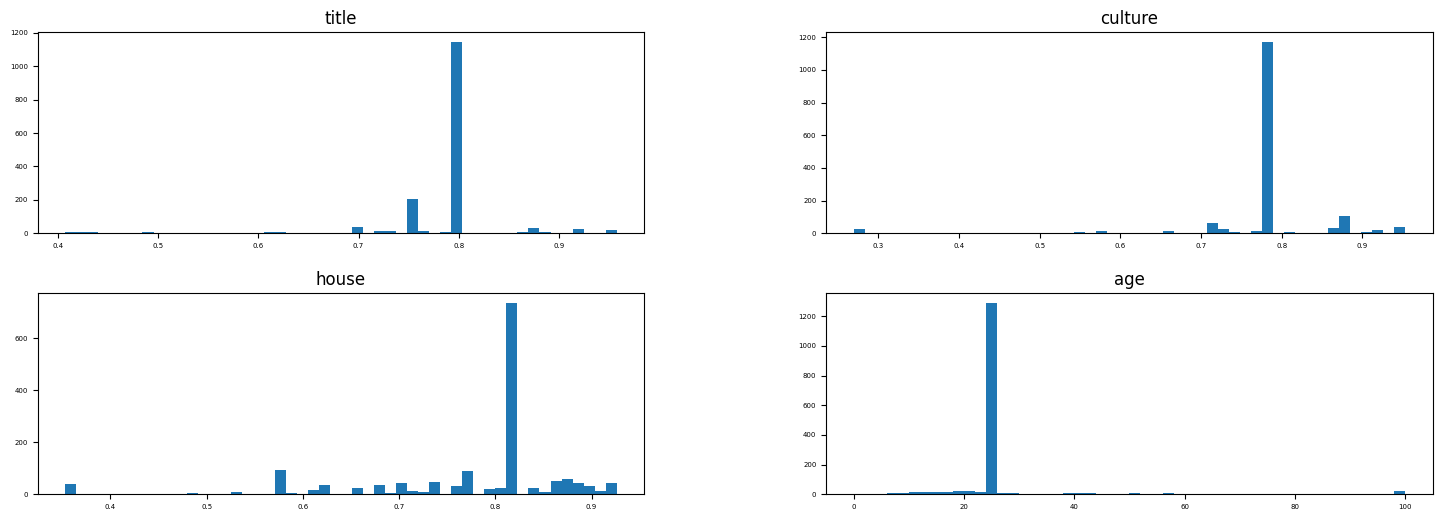

In [54]:
cols = ['title', 'culture', 'house', 'age']
features = df_train_clean[cols]
features.hist(figsize=(18, 6), bins=50,xlabelsize=5, ylabelsize=5, grid=False);

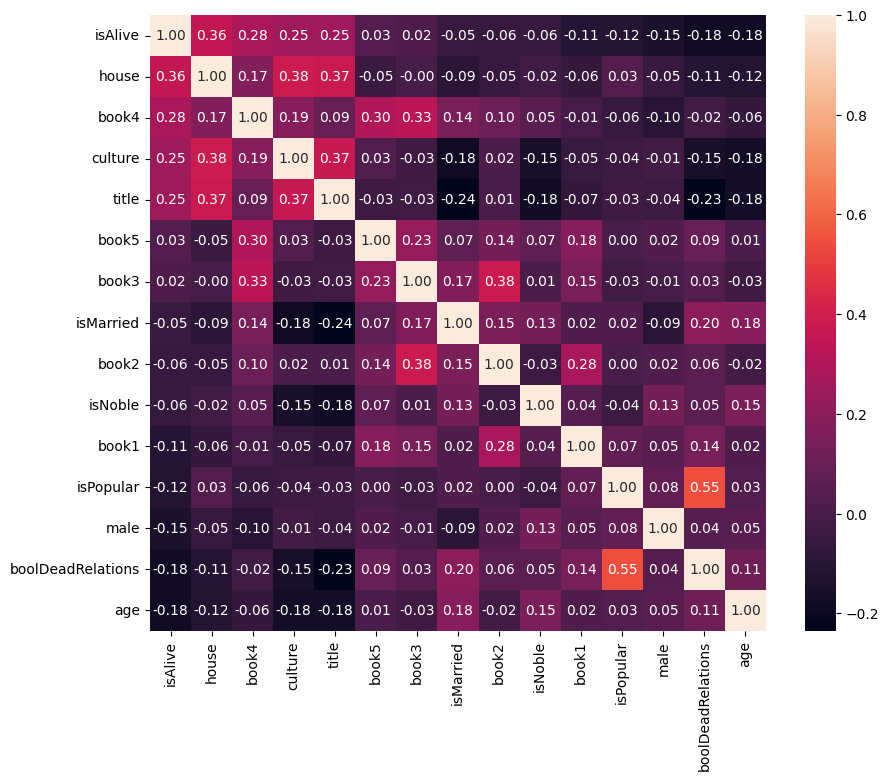

In [55]:
# correlation matrix
corrmat = df_train_clean.corr()

k = 15 # number of variables for heatmap
cols = corrmat.nlargest(k, 'isAlive')['isAlive'].index
cm = np.corrcoef(df_train_clean[cols].values.T)

plt.figure(figsize=(10, 8))

hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

isAlive
0    16
1    11
Name: count, dtype: int64
isAlive
1    1201
0     329
Name: count, dtype: int64


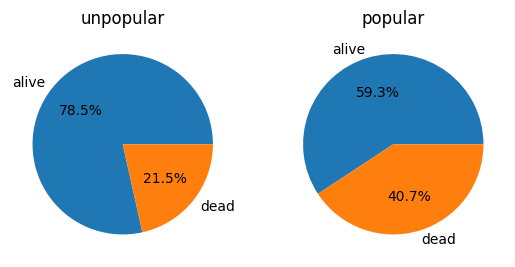

In [56]:
# how does popularity influence being alive
popular = df_train_clean[df_train_clean['isPopular'] == 1]['isAlive'].value_counts()
unpopular = df_train_clean[df_train_clean['isPopular'] == 0]['isAlive'].value_counts()

print(popular)
print(unpopular)

# build pie plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# unpopular
ax1.pie(unpopular, labels=['alive', 'dead'], autopct='%1.1f%%')
ax1.set_title('unpopular')

# unpopular
ax2.pie(popular, labels=['alive', 'dead'], autopct='%1.1f%%')
ax2.set_title('popular')

plt.show()

isAlive
0    39
1    30
Name: count, dtype: int64
isAlive
1    1182
0     306
Name: count, dtype: int64


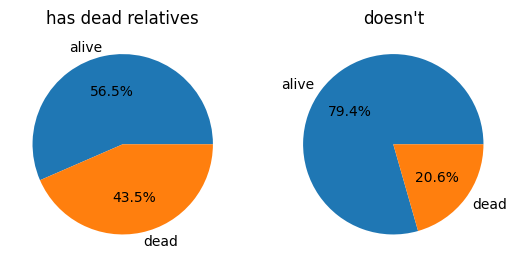

In [57]:
# how does presence of dead realatives influence being alive
has_deadrel = df_train_clean[df_train_clean['boolDeadRelations'] == 1]['isAlive'].value_counts()
no_deadrel = df_train_clean[df_train_clean['boolDeadRelations'] == 0]['isAlive'].value_counts()

print(has_deadrel)
print(no_deadrel)

# build pie plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# has_deadrel
ax1.pie(has_deadrel, labels=['alive', 'dead'], autopct='%1.1f%%')
ax1.set_title('has dead relatives')

# no_deadrel
ax2.pie(no_deadrel, labels=['alive', 'dead'], autopct='%1.1f%%')
ax2.set_title('doesn\'t')

plt.show()

isAlive
1    669
0    251
Name: count, dtype: int64
isAlive
1    543
0     94
Name: count, dtype: int64


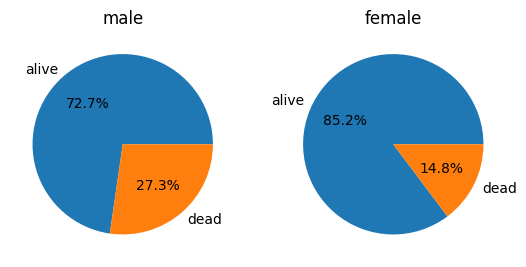

In [58]:
# compare males with females
male = df_train_clean[df_train_clean['male'] == 1]['isAlive'].value_counts()
female = df_train_clean[df_train_clean['male'] == 0]['isAlive'].value_counts()

print(male)
print(female)

# build pie plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# male
ax1.pie(male, labels=['alive', 'dead'], autopct='%1.1f%%')
ax1.set_title('male')

# female
ax2.pie(female, labels=['alive', 'dead'], autopct='%1.1f%%')
ax2.set_title('female')

plt.show()

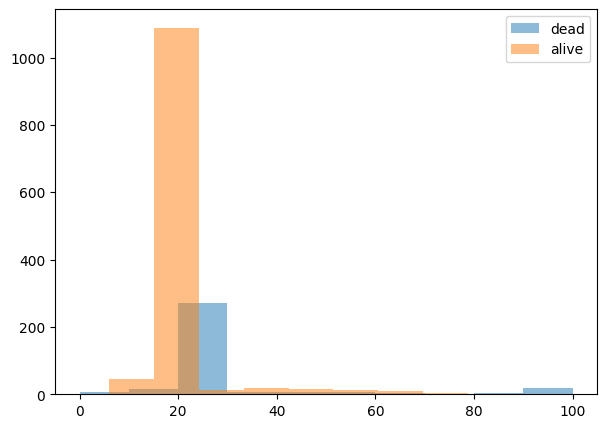

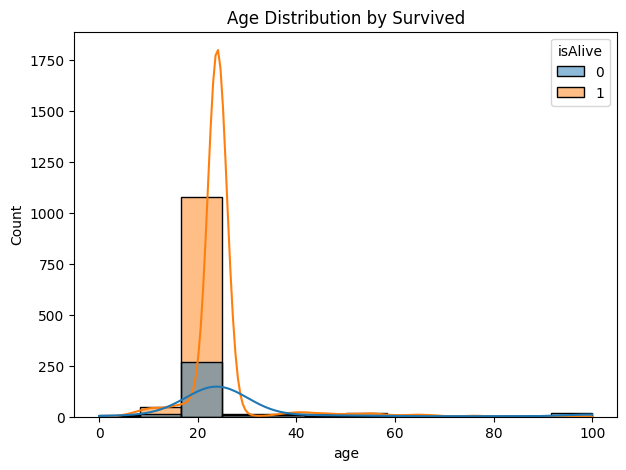

In [59]:
# look at age

# first plot
plt.figure(figsize=(7, 5))
plt.hist(df_train_clean['age'][df_train_clean['isAlive'] == 0], alpha=0.5, label='dead')
plt.hist(df_train_clean['age'][df_train_clean['isAlive'] == 1], alpha=0.5, label='alive')
plt.legend()
plt.show()

# second plot
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train_clean, x='age', kde=True, hue='isAlive')
plt.title('Age Distribution by Survived')
plt.show()

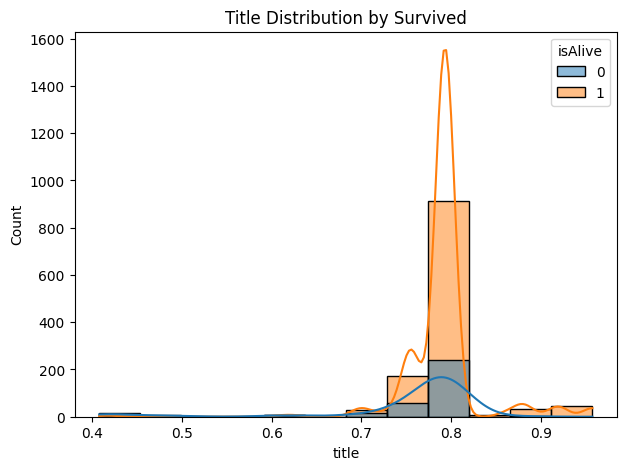

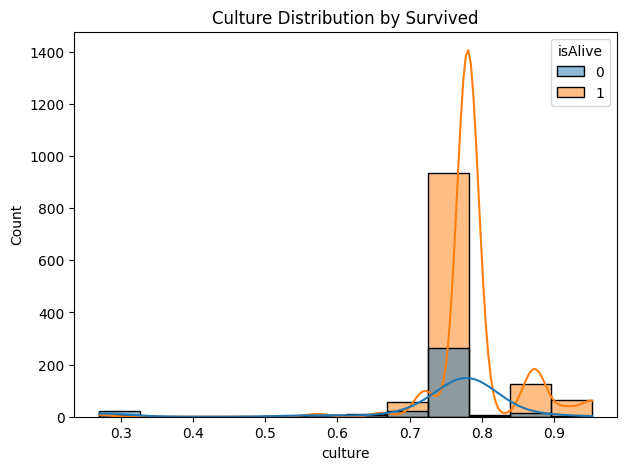

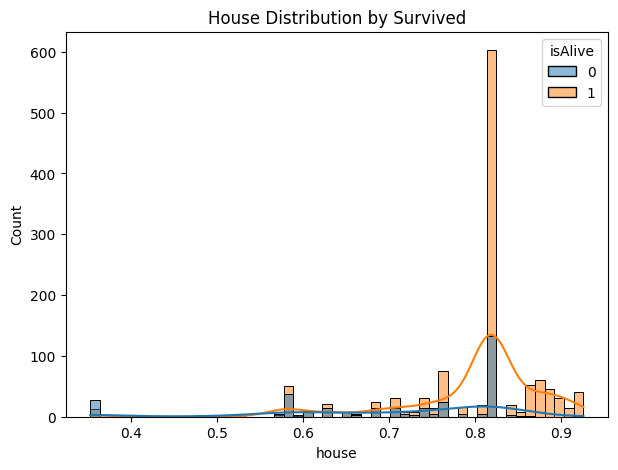

In [60]:
# look at encoded categories

# title
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train_clean, x='title', kde=True, hue='isAlive')
plt.title('Title Distribution by Survived')
plt.show()

# culture
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train_clean, x='culture', kde=True, hue='isAlive')
plt.title('Culture Distribution by Survived')
plt.show()

# house
plt.figure(figsize=(7, 5))
sns.histplot(data=df_train_clean, x='house', kde=True, hue='isAlive')
plt.title('House Distribution by Survived')
plt.show()

### Теперь объединим полученные результаты в одном **pipeline**

In [63]:
set_config(transform_output="pandas")  # set default outputs for the Transformers to be dataframes

In [64]:
logging.basicConfig(
    # level=logging.DEBUG,
    level=logging.INFO,
    # level=logging.WARNING,
    format="{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M",
)

class bcolors:
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'

# Custom transformers' definitions

In [65]:
"""
custom transformer for removing columns with 
percentage of NaN elements higher than threshold
"""
class HighNaNColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):  
        # public fields
        self.threshold = threshold

        # private fields
        self.columns_to_drop_ = None
        self.feature_names_in_ = None

    
    # learn from data
    def fit(self, X, y=None):
        # ensure X is a dataframe
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # set data for 'get_feature_names_out' method
        self.feature_names_in_ = X.columns.to_list()

        n = len(X)  # amount of columns

        # amount of NaN elements in each column
        NaN_count = X.isna().sum(axis=0)  

        # percentage of NaN elements in each column
        NaN_percentage = NaN_count / n

        # columns with high percentage of NaN elements
        self.columns_to_drop_ = NaN_percentage[NaN_percentage >= self.threshold].index.to_list()

        # fit method must return self
        return self
    
    
    # apply transformations
    def transform(self, X, y=None):
        check_is_fitted(self) # Ensures fit has been called
        # create a copy (in order to avoid modifying the original X)
        X = copy.deepcopy(X)
        
        # ensure columns exist
        columns_to_drop_existing = [col for col in self.columns_to_drop_ if col in X]

        # drop columns with high percentage of NaN elements
        X.drop(columns=columns_to_drop_existing, inplace=True)

        logging.debug(f"{bcolors.OKGREEN}[HighNaNColumnDropper] Dropped columns: {columns_to_drop_existing}. Shape after drop: {X.shape}")

        return X


    """
    get output feature names for transformation
    """
    # input_features argument: a list of names from the previous step in a pipeline
    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self) # Ensures fit has been called
        if input_features is None:
            input_features = self.feature_names_in_
            if input_features is None:
                raise ValueError(f"{bcolors.FAIL}Cannot get output names without input features or fit.")
            
        return [col for col in input_features if col not in self.columns_to_drop_]

In [66]:
"""
create 'output_col' feature based on the 'input_col' column and 
some threshold
e.g.: 
isPopular = 1 if popularity > 0.8 else 0
boolDeadRelations = 1 if numDeadRelations > 0 else 0
"""
class ColumnBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold, input_col, 
                                  output_col):  
        # public fields
        self.threshold  = threshold
        self.input_col  = input_col
        self.output_col = output_col

        # private fields
        self.feature_names_in_ = None
    

    # learn from data
    def fit(self, X, y=None):
        # ensure X is a dataframe
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # ensure input_col exists
        if self.input_col not in X:
            raise ValueError(f"{bcolors.FAIL}Input column '{self.input_col}' not found in DataFrame during fit.")

        # set data for 'get_feature_names_out' method
        self.feature_names_in_ = X.columns.to_list()

        # fit method must return self
        return self
    
    
    # apply transformations
    def transform(self, X, y=None):
        check_is_fitted(self) # Ensures fit has been called
        # create a copy (in order to avoid modifying the original X)
        X = copy.deepcopy(X)
        
        # ensure input_col exists
        if self.input_col not in X:
            logging.warning(f"{bcolors.WARNING}[ColumnBinarizer] Warning: Column '{self.input_col}' not found. Skipping.")
            return X

        # replace existing feature with a new one
        # or leave NaN 
        condition = pd.isna(X[self.input_col])

        value_if_True  = np.nan
        value_if_False = (X[self.input_col] > self.threshold).astype(int)

        X[self.input_col] = np.where(condition, value_if_True, value_if_False)

        X.rename(columns={self.input_col: self.output_col}, inplace=True)

        logging.debug(f"{bcolors.OKGREEN}[ColumnBinarizer] Renamed column: {self.input_col} -> {self.output_col}")

        return X
    

    """
    get output feature names for transformation
    """
    # input_features argument: a list of names from the previous step in a pipeline
    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self) # Ensures fit has been called
        if input_features is None:
            input_features = self.feature_names_in_
            if input_features is None:
                raise ValueError(f"{bcolors.FAIL}Cannot get output names without input features or fit.")
            
        return [self.output_col if col == self.input_col else col for col in input_features]

In [67]:
"""
simplify a category, based on 'instructions_map': 
combine multiple columns into a single one
e.g.:
instructions_map = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari':       ['ghiscari', 'ghiscaricari',  'ghis'],
    'Asshai':         ["asshai'i", 'asshai']
}
"""
class ColumnSimplifier(BaseEstimator, TransformerMixin):
    def __init__(self, input_col, instructions_map):  
        # public fields
        self.input_col = input_col
        self.instructions_map = instructions_map

        # private fields
        self.feature_names_in_ = None
        self.reverse_map_ = None


    """
    Helper method to build the reverse map.
    """
    def _build_reverse_map(self):
        # create a reverse map for efficient replacement
        self.reverse_map_ = {}
        for replacement, variations in self.instructions_map.items():
            replacement = replacement.lower()  # standardize

            # ensure variations is a list
            if isinstance(variations, str):
                variations = [variations]

            for variation in variations:
                self.reverse_map_[variation.lower()] = replacement

            # ensure replacement maps to itself
            self.reverse_map_[replacement] = replacement


    # learn from data
    def fit(self, X, y=None):
        # ensure X is a dataframe
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # ensure input_col exists
        if self.input_col not in X:
            raise ValueError(f"{bcolors.FAIL}Input column '{self.input_col}' not found in DataFrame during fit.")

        self._build_reverse_map()

        # set data for 'get_feature_names_out' method
        self.feature_names_in_ = X.columns.to_list()

        # fit method must return self
        return self
    
    
    # apply transformations
    def transform(self, X, y=None):
        check_is_fitted(self) # Ensures fit has been called
        # create a copy (in order to avoid modifying the original X)
        X = copy.deepcopy(X)

        # ensure input_col exists
        if self.input_col not in X:
             logging.warning(f"{bcolors.WARNING}[ColumnSimplifier] Warning: Column '{self.input_col}' not found in transform data. Skipping.")
             return X

        # lower feature names
        feature_values_lower = X[self.input_col].astype('str').str.lower()

        # simplify data based on instructions dict
        X[self.input_col] = feature_values_lower.map(self.reverse_map_).fillna(feature_values_lower)  # fillna keeps original if no map found

        logging.debug(f"{bcolors.OKGREEN}[ColumnSimplifier] Simplified {self.input_col}")

        return X
    

    """
    get output feature names for transformation
    """
    # input_features argument: a list of names from the previous step in a pipeline
    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self) # Ensures fit has been called
        if input_features is None:
            input_features = self.feature_names_in_
            if input_features is None:
                raise ValueError(f"{bcolors.FAIL}Cannot get output names without input features or fit.")
            
        return input_features

In [68]:
"""
drop uninformative columns
(ColumnTransformer can also do simple dropping: ('drop_cols', 'drop', COLS_TO_DROP))
"""
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):  
        # public fields

        # Ensure it's a list
        if isinstance(columns_to_drop, str):
            self.columns_to_drop = [columns_to_drop]
        else:
            self.columns_to_drop = columns_to_drop

        # private fields
        self.feature_names_in_ = None


    # learn from data
    def fit(self, X, y=None):
        # ensure X is a dataframe
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        # set data for 'get_feature_names_out' method
        self.feature_names_in_ = X.columns.to_list()

        # fit method must return self
        return self
    
    
    # apply transformations
    def transform(self, X, y=None):
        check_is_fitted(self) # Ensures fit has been called
        # create a copy (in order to avoid modifying the original X)
        X = copy.deepcopy(X)

        # drop columns
        cols_to_drop_existing = [col for col in self.columns_to_drop if col in X]
        
        if cols_to_drop_existing:
            X.drop(columns=cols_to_drop_existing, inplace=True)
            logging.debug(f"{bcolors.OKGREEN}[ColumnDropper] Columns dropped: {self.columns_to_drop}. Shape: {X.shape}")
        else:
            logging.warning(f"{bcolors.WARNING}[ColumnDropper] Warning: No columns to drop found in this dataset.")

        return X
    

    """
    get output feature names for transformation
    """
    # input_features argument: a list of names from the previous step in a pipeline
    def get_feature_names_out(self, input_features=None):
        check_is_fitted(self) # Ensures fit has been called
        if input_features is None:
            input_features = self.feature_names_in_
            if input_features is None:
                raise ValueError(f"{bcolors.FAIL}Cannot get output names without input features or fit.")
            
        dropped_set = set(self.columns_to_drop)
        return [col for col in input_features if col not in dropped_set]

# Define constants

In [69]:
# COLS_TO_DROP = ['name', 'dateOfBirth']  # set uninformative cols
COLS_TO_DROP = ['name']  # set uninformative cols

NAN_DROPPER_THRESHOLD = 85    # in percents (e.g. 85 means that columns that have more than 85% of NaN values will be dropped)
BIN_RARE_THRESHOLD    = 0.01  # not in percents (e.g. 0.01 ~ 1% means that colums that appear 1% or less of the time go to the 'RARE' column)
POPULARITY_THRESHOLD  = 0.5 

SMOOTHING_REGULARIZATION_PARAMETER = 5  # for target encoding

COL_TO_SIMPLIFY = 'culture'  # set column name to simplify
SIMPLIFY_INSTRUCTIONS_MAP = {
    'Summer Islands': ['summer islands', 'summer islander', 'summer isles'],
    'Ghiscari': ['ghiscari', 'ghiscaricari', 'ghis'],
    'Asshai': ["asshai'i", 'asshai'],
    'Lysene': ['lysene', 'lyseni'],
    'Andal': ['andal', 'andals'],
    'Braavosi': ['braavosi', 'braavos'],
    'Dornish': ['dornishmen', 'dorne', 'dornish'],
    'Myrish': ['myr', 'myrish', 'myrmen'],
    'Westermen': ['westermen', 'westerman', 'westerlands'],
    'Westerosi': ['westeros', 'westerosi'],
    'Stormlander': ['stormlands', 'stormlander'],
    'Norvoshi': ['norvos', 'norvoshi'],
    'Northmen': ['the north', 'northmen'],
    'Free Folk': ['wildling', 'first men', 'free folk'],
    'Qartheen': ['qartheen', 'qarth'],
    'Reach': ['the reach', 'reach', 'reachmen'],
}

TARGET_COL = 'isAlive'

# Load data

In [70]:
# refresh data
df = pd.read_csv('content/game_of_thrones_train.csv', index_col='S.No')
df_test_final = pd.read_csv('content/game_of_thrones_test.csv', index_col='S.No')

# Split data

In [71]:
# perform the split BEFORE all the data processing
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=True, 
    random_state=42, 
    stratify=y  # recommended for calssification problems
)

# reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# Define models

In [72]:
# define models with default parameters for initial comparison
MODELS = {
    'Baseline': DummyClassifier(strategy='most_frequent', random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
    'GaussianProcess': GaussianProcessClassifier(random_state=42),
    'GaussianNB': GaussianNB(),
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(probability=True, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42)
}

# Cross-Validation for scoring

In [73]:
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [74]:
cv_results = {}
cv_times = {}

logging.info(f'--- Running Cross-Validation ---')

for model_name, model in MODELS.items():
    # start timer
    start_time = time.time()

    # define the full pipeline
    pipeline = Pipeline([
        # -----------------------
        # STEP 1: PREPROCESS DATA
        # -----------------------

        # drop columns with high percentage of NaN values
        ('drop_cols_with_high_NaN', HighNaNColumnDropper(threshold=NAN_DROPPER_THRESHOLD)),

        # drop uninformative columns
        ('drop_uninformative', ColumnDropper(COLS_TO_DROP)),

        # simplify 'culture' column, according to 'instructions_map'
        ('simplify', ColumnSimplifier(COL_TO_SIMPLIFY, SIMPLIFY_INSTRUCTIONS_MAP)),

        # feature engineering: create 'isPopular'
        # i.e. isPopular = 1 if popularity > threshold else 0 
        ('binarize_popularity', ColumnBinarizer(POPULARITY_THRESHOLD, 'popularity', 'isPopular')), 

        # feature engineering: create 'boolDeadRelations'
        # i.e. boolDeadRelations = 1 if numDeadRelations > threshold else 0
        ('binarize_deadrelations', ColumnBinarizer(0, 'numDeadRelations', 'boolDeadRelations')),

        # fill missing values and encode categorical data
        ('preprocessing', ColumnTransformer(
            transformers=[
                # process categorical data
                ('categorical', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing values with mode
                    ('bin_rare', RareLabelEncoder(tol=BIN_RARE_THRESHOLD)),  # bin rare 
                    ('target_encoder', TargetEncoder(smoothing=SMOOTHING_REGULARIZATION_PARAMETER))  # apply target encoding 
                ]), make_column_selector(dtype_include=object)),  # apply this pipeline to ALL of the categorical data 

                # process numerical data
                ('numerical', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),  # fill missing values with mean
                    ('scaler', StandardScaler()),  # not needed for tree models
                # use selector here to automatically pick up the newly created
                # numerical columns along with other numerical columns.
                ]), make_column_selector(dtype_include=np.number))  # apply this pipeline to ALL of the numerical data 
            ],
            remainder='passthrough'  # keep columns not explicitly handled by transformers above
            # Verbose can be helpful for debugging column transformations: verbose_feature_names_out=True
        )),

        # add resampling?

        # -------------
        # STEP 2: MODEL
        # -------------

        (f'model_{model_name.lower()}', model)
    ])

    # perform cross-validation
    scorers = {
        'accuracy': 'accuracy', 
        'f1_weighted': 'f1_weighted',
        'f1_macro': 'f1_macro', 
        'roc_auc': 'roc_auc',
    }
    scores = cross_validate(pipeline, X_train, y_train, cv=cv_strategy, scoring=scorers, n_jobs=-1)

    # remember the results
    cv_results[model_name] = {
        'fit_time': scores['fit_time'].mean(),
        'score_time': scores['score_time'].mean(),
        'accuracy': scores['test_accuracy'].mean(),
        'accuracy_std': scores['test_accuracy'].std(),
        'f1_weighted': scores['test_f1_weighted'].mean(),
        'f1_weighted_std': scores['test_f1_weighted'].std(),
        'f1_macro': scores['test_f1_macro'].mean(),
        'f1_macro_std': scores['test_f1_macro'].std(),
        'roc_auc': scores['test_roc_auc'].mean(),
        'roc_auc_std': scores['test_roc_auc'].std(),
    }

    # end timer
    end_time = time.time()

    cv_times[model_name] = end_time - start_time
    logging.info(f"Finished CV for {model_name} in {cv_times[model_name]:.2f} seconds")
    logging.info(f"  Avg Accuracy: {cv_results[model_name]['accuracy']:.4f} +/- {cv_results[model_name]['accuracy_std']:.4f}")
    logging.info(f"  Avg F1_weighted: {cv_results[model_name]['f1_weighted']:.4f} +/- {cv_results[model_name]['f1_weighted_std']:.4f}")
    logging.info(f"  Avg F1_macro: {cv_results[model_name]['f1_macro']:.4f} +/- {cv_results[model_name]['f1_macro_std']:.4f}")
    logging.info(f"  Avg ROC AUC: {cv_results[model_name]['roc_auc']:.4f} +/- {cv_results[model_name]['roc_auc_std']:.4f}")

2025-07-13 05:11 - INFO - --- Running Cross-Validation ---
2025-07-13 05:11 - INFO - Finished CV for Baseline in 1.84 seconds
2025-07-13 05:11 - INFO -   Avg Accuracy: 0.7783 +/- 0.0033
2025-07-13 05:11 - INFO -   Avg F1_weighted: 0.6813 +/- 0.0045
2025-07-13 05:11 - INFO -   Avg F1_macro: 0.4377 +/- 0.0010
2025-07-13 05:11 - INFO -   Avg ROC AUC: 0.5000 +/- 0.0000
2025-07-13 05:11 - INFO - Finished CV for LogisticRegression in 0.94 seconds
2025-07-13 05:11 - INFO -   Avg Accuracy: 0.8314 +/- 0.0258
2025-07-13 05:11 - INFO -   Avg F1_weighted: 0.7938 +/- 0.0375
2025-07-13 05:11 - INFO -   Avg F1_macro: 0.6590 +/- 0.0659
2025-07-13 05:11 - INFO -   Avg ROC AUC: 0.7888 +/- 0.0344
2025-07-13 05:11 - INFO - Finished CV for RandomForest in 0.63 seconds
2025-07-13 05:11 - INFO -   Avg Accuracy: 0.7977 +/- 0.0255
2025-07-13 05:11 - INFO -   Avg F1_weighted: 0.7806 +/- 0.0274
2025-07-13 05:11 - INFO -   Avg F1_macro: 0.6614 +/- 0.0428
2025-07-13 05:11 - INFO -   Avg ROC AUC: 0.7813 +/- 0.0416


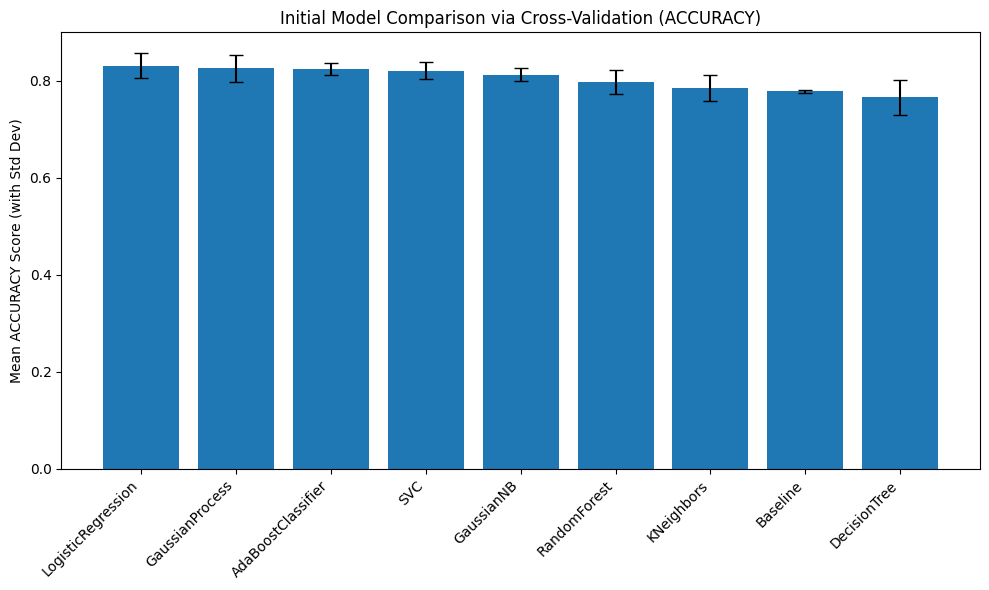

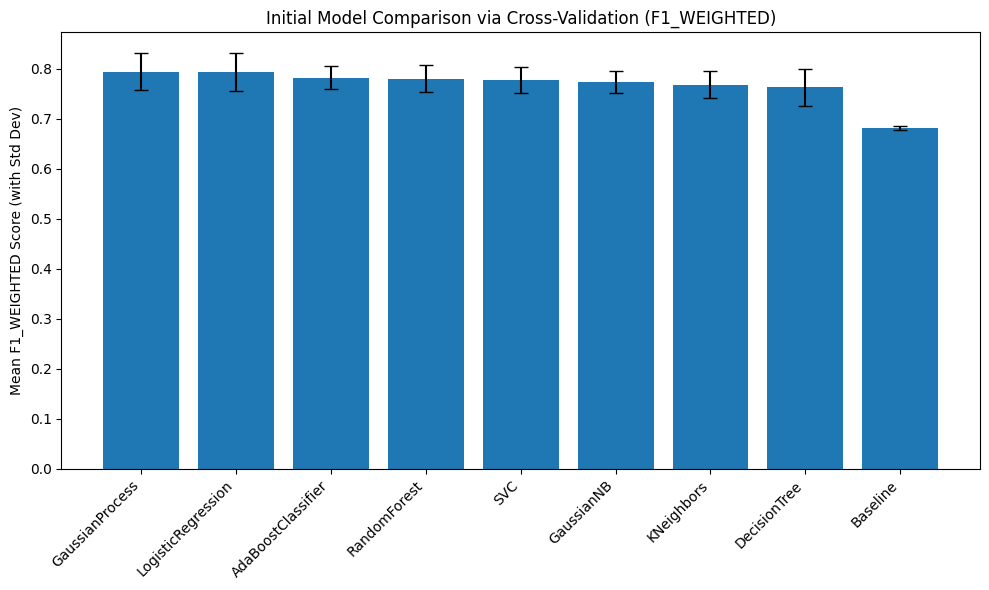

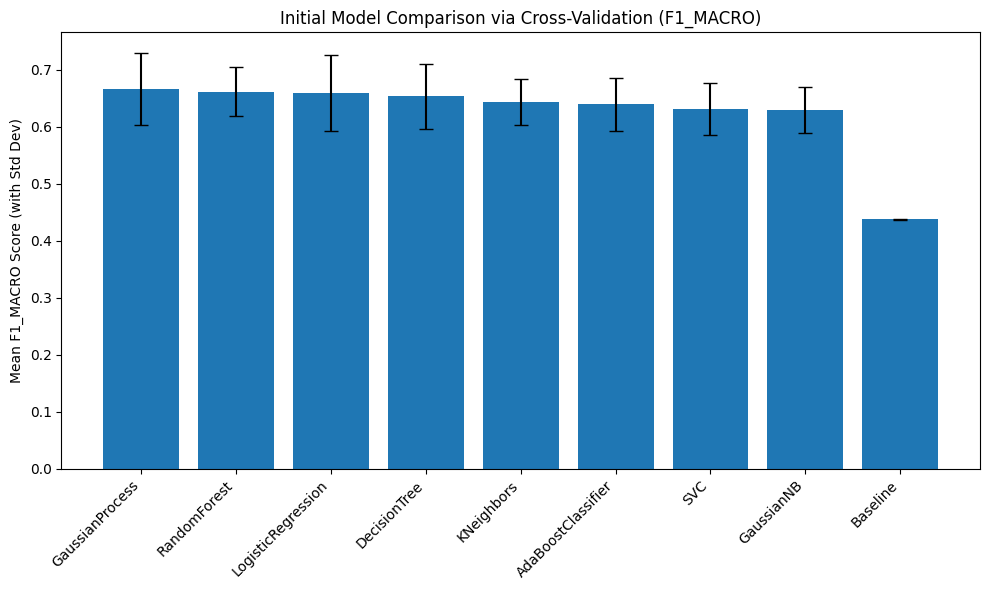

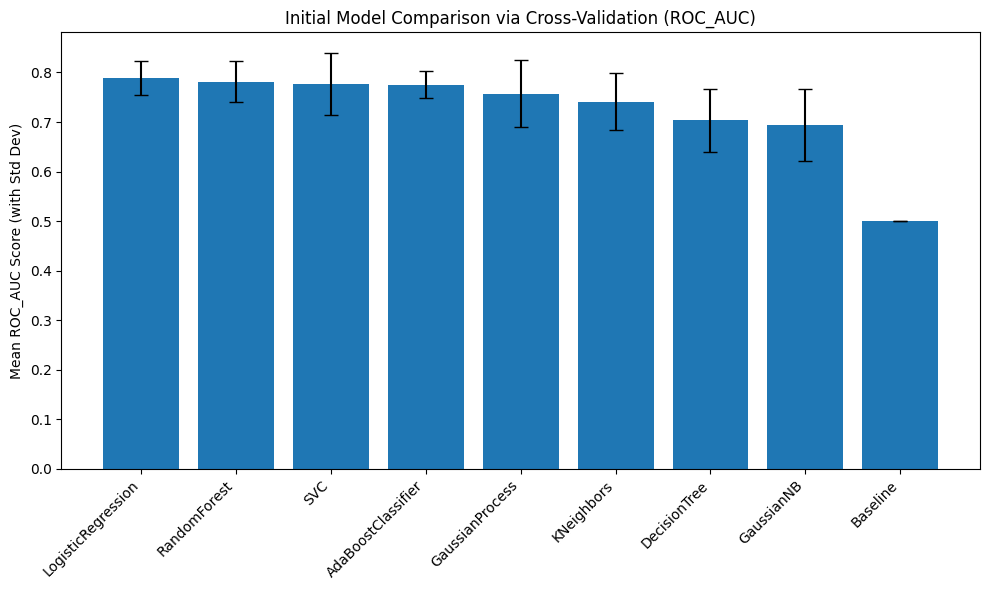

In [75]:
# plot the results
results_df = pd.DataFrame(cv_results).T 

scorers = ['accuracy', 'f1_weighted', 'f1_macro', 'roc_auc']

for scorer in scorers:
    # sort by metric
    results_df = results_df.sort_values(by=scorer, ascending=False) 

    plt.figure(figsize=(10, 6))

    plt.bar(results_df.index, results_df[scorer], yerr=results_df[f'{scorer}_std'], capsize=5)
    plt.ylabel(f"Mean {scorer.upper()} Score (with Std Dev)")
    plt.title(f"Initial Model Comparison via Cross-Validation ({scorer.upper()})")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [76]:
# check balance
y_train.value_counts(normalize=True)

isAlive
1    0.778313
0    0.221687
Name: proportion, dtype: float64

# Cross-Validation for hyperparameter tuning

Given the dataset imbalance (78/22 split), we will use ROC AUC metric as it is robust to imbalance

In [ ]:
logging.info("\n--- Running Hyperparameter Tuning ---")

PREPROCESSING_PARAMS = {
    'drop_cols_with_high_NaN__threshold': uniform(loc=0.85, scale=0.15),
    'preprocessing__categorical__bin_rare__tol': uniform(loc=0, scale=0.1),
    'preprocessing__categorical__target_encoder__smoothing': uniform(loc=1, scale=30),
    'binarize_popularity__threshold': uniform(loc=0.5, scale=0.5),
}

# define kernels for Gaussian Process model testing
kernel_rbf = C_kern(1.0) * RBF(length_scale=1.0)
kernel_matern = C_kern(1.0) * Matern(length_scale=1.0, nu=1.5)

# define parameter grids for models and preprocessing steps
# syntax: 'step_name__parameter_name' 
PARAM_GRID = {
    'RandomForest': {
        **PREPROCESSING_PARAMS,

        # RandomForest Model Params
        'model__n_estimators': randint(200, 700), 
        'model__max_depth': randint(5, 20), 
        'model__min_samples_leaf': randint(1, 5),
        'model__class_weight': ['balanced', None]    
    },
    'SVC': {
        **PREPROCESSING_PARAMS,

        # SVC Model Params
        'model__C': [0.1, 1, 10],
        'model__kernel': ['rbf', 'linear'],
        'model__gamma': ['scale', 'auto', 0.1],
        'model__class_weight': ['balanced', None]
    },
    'LogisticRegression': {
        **PREPROCESSING_PARAMS,

        # LogisticRegression Model Params
        'model__penalty': ['l2', None],
        'model__C': [0.005, 0.01, 0.1, 1, 10, 100],
        'model__solver': ['lbfgs', 'liblinear', 'saga'], 
        'model__class_weight': ['balanced', None]
    },
    'GaussianProcess': {
        **PREPROCESSING_PARAMS,

        # Gaussian Process Model Params
        'model__kernel': [
            None,
            kernel_rbf,
            kernel_matern,
            C_kern(1.0),
            # C_kern(1.0) * RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
        ],
        'model__n_restarts_optimizer': [0, 1, 3]
    }
}

# suppress warnings (works only without)
warnings.filterwarnings(
    action='ignore',
    message=r".*Setting penalty=None will ignore.*", 
    category=UserWarning,
)

warnings.filterwarnings(
    action='ignore',
    category=ConvergenceWarning
)

winner_search = None
for model_name in PARAM_GRID.keys():
    # check presence in MODELS
    if model_name not in MODELS:
         logging.warning(f"Model {model_name} found in PARAM_GRID but not in MODELS dictionary. Skipping.")
         continue
    
    # skip Baseline 
    if model_name == 'Baseline':
        continue
    
    logging.info(f"\n--- Running Hyperparameter Tuning for {model_name} ---")

    # redefine the pipeline *specifically for tuning*
    pipeline = Pipeline([
        # preprocessing
        ('drop_cols_with_high_NaN', HighNaNColumnDropper(threshold=NAN_DROPPER_THRESHOLD)),
        ('drop_uninformative', ColumnDropper(COLS_TO_DROP)),
        ('simplify', ColumnSimplifier(COL_TO_SIMPLIFY, SIMPLIFY_INSTRUCTIONS_MAP)),
        ('binarize_popularity', ColumnBinarizer(POPULARITY_THRESHOLD, 'popularity', 'isPopular')), 
        ('binarize_deadrelations', ColumnBinarizer(0, 'numDeadRelations', 'boolDeadRelations')),
        ('preprocessing', ColumnTransformer(
            transformers=[
                ('categorical', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('bin_rare', RareLabelEncoder(tol=BIN_RARE_THRESHOLD)),
                    ('target_encoder', TargetEncoder(smoothing=SMOOTHING_REGULARIZATION_PARAMETER))
                ]), make_column_selector(dtype_include=object)),
                ('numerical', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler()),
                ]), make_column_selector(dtype_include=np.number))
            ],
            remainder='passthrough'
        )),
        # model
        (f'model', MODELS[model_name])
    ])

    # Use a relevant scoring metric found important from CV

    search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=PARAM_GRID[model_name],
        # n_iter=1000,
        n_iter=100,
        scoring='roc_auc',
        # scoring='accuracy',
        cv=cv_strategy,
        n_jobs=-1,
        verbose=1,
        # random_state=42
    )

    # search = GridSearchCV(
    #     estimator=pipeline,
    #     param_grid=PARAM_GRID[model_name],
    #     scoring='roc_auc',
    #     cv=cv_strategy,
    #     n_jobs=-1,
    #     verbose=1
    # )

    start_time_hpt = time.time()

    # Fit the search object on TRAINING DATA ONLY
    search.fit(X_train, y_train)

    end_time_hpt = time.time()

    logging.info(f"\nFinished HPT for {model_name} in {(end_time_hpt - start_time_hpt):.2f} seconds")
    logging.info(f"Best parameters found for {model_name}:")
    logging.info(search.best_params_)
    logging.info(f"\nBest cross-validation score (ROC AUC) for tuned {model_name}:")
    logging.info(search.best_score_)

    # save best model
    if winner_search is None:
        winner_search = copy.deepcopy(search)
    else:
        if search.best_score_ > winner_search.best_score_:
            winner_search = copy.deepcopy(search)
        elif search.best_score_ == winner_search.best_score_:
            logging.warning(f'Found models with the same best_score_')

2025-07-13 05:11 - INFO - 
--- Running Hyperparameter Tuning ---
2025-07-13 05:11 - INFO - 
--- Running Hyperparameter Tuning for RandomForest ---


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


2025-07-13 05:13 - INFO - 
Finished HPT for RandomForest in 115.10 seconds
2025-07-13 05:13 - INFO - Best parameters found for RandomForest:
2025-07-13 05:13 - INFO - {'binarize_popularity__threshold': 0.568473692580958, 'drop_cols_with_high_NaN__threshold': 0.8852878743052698, 'model__class_weight': None, 'model__max_depth': 18, 'model__min_samples_leaf': 4, 'model__n_estimators': 426, 'preprocessing__categorical__bin_rare__tol': 0.029429077386761628, 'preprocessing__categorical__target_encoder__smoothing': 5.5451440001718755}
2025-07-13 05:13 - INFO - 
Best cross-validation score (ROC AUC) for tuned RandomForest:
2025-07-13 05:13 - INFO - 0.8033706720804015


# Final evaluation

2025-07-13 05:13 - INFO - 
--- Final Evaluation on Test Set ---
2025-07-13 05:13 - INFO - 
Classification Report on Test Set (Tuned RandomForestClassifier):
2025-07-13 05:13 - INFO - 
              precision    recall  f1-score   support

           0       0.70      0.20      0.31        69
           1       0.81      0.98      0.89       243

    accuracy                           0.80       312
   macro avg       0.76      0.59      0.60       312
weighted avg       0.79      0.80      0.76       312

2025-07-13 05:13 - INFO - ROC AUC Score on Test Set (Tuned RandomForestClassifier): 0.7953
2025-07-13 05:13 - INFO - ACCURACY Score on Test Set (Tuned RandomForestClassifier): 0.8045
2025-07-13 05:13 - INFO - 
Baseline ROC AUC Score on Test Set:
2025-07-13 05:13 - INFO - 0.5000
2025-07-13 05:13 - INFO - 
Baseline Accuracy Score on Test Set:
2025-07-13 05:13 - INFO - 0.7788


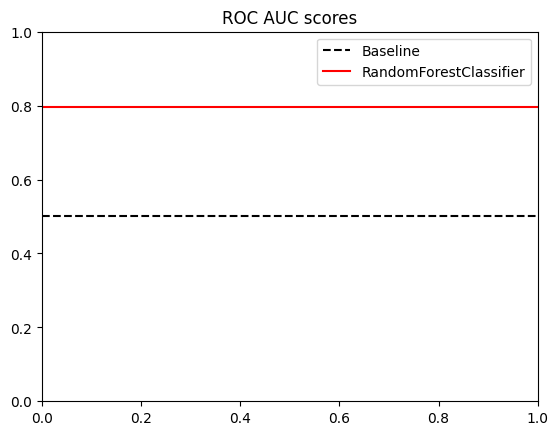

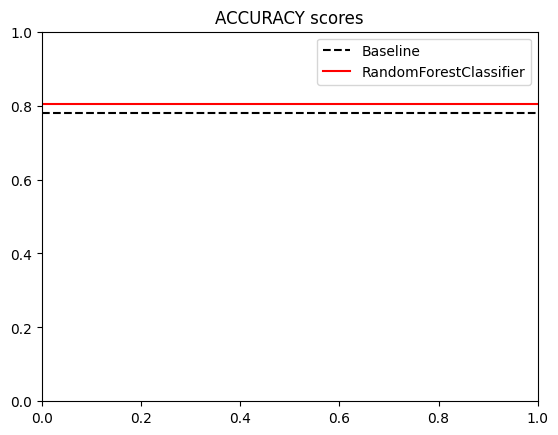

In [78]:
logging.info("\n--- Final Evaluation on Test Set ---")

best_pipeline = winner_search.best_estimator_
best_model_type = type(winner_search.best_estimator_.named_steps['model'])
best_model_name = best_model_type.__name__

# predict on test data
y_pred_test  = best_pipeline.predict(X_test)
y_proba_test = best_pipeline.predict_proba(X_test)[:, 1]  # get probabilities for roc auc

# evaluate
logging.info(f"\nClassification Report on Test Set (Tuned {best_model_name}):")
logging.info(f'\n{classification_report(y_test, y_pred_test)}')

# roc auc
roc_auc = roc_auc_score(y_test, y_proba_test)
logging.info(f"ROC AUC Score on Test Set (Tuned {best_model_name}): {roc_auc:.4f}")

# accuracy
accuracy = accuracy_score(y_test, y_pred_test)
logging.info(f"ACCURACY Score on Test Set (Tuned {best_model_name}): {accuracy:.4f}")

# compare with baseline
# redefine the pipeline *specifically for baseline*
pipeline_baseline = Pipeline([
    # preprocessing
    ('drop_cols_with_high_NaN', HighNaNColumnDropper(threshold=NAN_DROPPER_THRESHOLD)),
    ('drop_uninformative', ColumnDropper(COLS_TO_DROP)),
    ('simplify', ColumnSimplifier(COL_TO_SIMPLIFY, SIMPLIFY_INSTRUCTIONS_MAP)),
    ('binarize_popularity', ColumnBinarizer(POPULARITY_THRESHOLD, 'popularity', 'isPopular')), 
    ('binarize_deadrelations', ColumnBinarizer(0, 'numDeadRelations', 'boolDeadRelations')),
    ('preprocessing', ColumnTransformer(
        transformers=[
            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('bin_rare', RareLabelEncoder(tol=BIN_RARE_THRESHOLD)),
                ('target_encoder', TargetEncoder(smoothing=SMOOTHING_REGULARIZATION_PARAMETER))
            ]), make_column_selector(dtype_include=object)),
            ('numerical', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
            ]), make_column_selector(dtype_include=np.number))
        ],
        remainder='passthrough'
    )),
    # model
    ('model', MODELS['Baseline'])
])

# predict with baseline
pipeline_baseline.fit(X_train, y_train)
y_pred_test_baseline = pipeline_baseline.predict(X_test)

# roc auc baseline
roc_auc_baseline = roc_auc_score(y_test, y_pred_test_baseline)
logging.info("\nBaseline ROC AUC Score on Test Set:")
logging.info(f"{roc_auc_baseline:.4f}")

# accuracy baseline
accuracy_baseline = accuracy_score(y_test, y_pred_test_baseline)
logging.info("\nBaseline Accuracy Score on Test Set:")
logging.info(f"{accuracy_baseline:.4f}")

# plot the results (ROC AUC)
fig, ax = plt.subplots()

# plot baseline result
plt.axhline(y=roc_auc_baseline, color='black', linestyle='--', label='Baseline')

# plot best model result
plt.axhline(y=roc_auc, color='red', label=f'{best_model_name}')

plt.title('ROC AUC scores')
plt.legend()

plt.show()

# plot the results (ACCURACY)
fig, ax = plt.subplots()

# plot baseline result
plt.axhline(y=accuracy_baseline, color='black', linestyle='--', label='Baseline')

# plot best model result
plt.axhline(y=accuracy, color='red', label=f'{best_model_name}')

plt.title('ACCURACY scores')
plt.legend()

plt.show()

# Submission

let's now redefine the whole pipeline with best found parameters and a best found model

In [79]:
# final reload
df_train = pd.read_csv('content/game_of_thrones_train.csv', index_col='S.No')
df_test  = pd.read_csv('content/game_of_thrones_test.csv', index_col='S.No')

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

In [ ]:
# define best found parameters
BEST_PARAMS = {
    # preprocessing params
    'drop_cols_with_high_NaN__threshold': np.float64(0.9872551370164556),
    'preprocessing__categorical__bin_rare__tol': np.float64(0.01276096229354561),
    'preprocessing__categorical__target_encoder__smoothing': np.float64(20.66054888950383),
    'binarize_popularity__threshold': np.float64(0.9358130957616262),

    # RandomForest model params
    'model__n_estimators': 340, 
    'model__max_depth': 15, 
    'model__min_samples_leaf': 2,
    'model__class_weight': None  
}

# define the final full pipeline
final_pipeline = Pipeline([
    # -----------------------
    # STEP 1: PREPROCESS DATA
    # -----------------------

    # drop columns with high percentage of NaN values
    ('drop_cols_with_high_NaN', HighNaNColumnDropper(threshold=BEST_PARAMS['drop_cols_with_high_NaN__threshold'])),

    # drop uninformative columns
    ('drop_uninformative', ColumnDropper(COLS_TO_DROP)),

    # simplify 'culture' column, according to 'instructions_map'
    ('simplify', ColumnSimplifier(COL_TO_SIMPLIFY, SIMPLIFY_INSTRUCTIONS_MAP)),

    # feature engineering: create 'isPopular'
    # i.e. isPopular = 1 if popularity > threshold else 0 
    ('binarize_popularity', ColumnBinarizer(BEST_PARAMS['binarize_popularity__threshold'], 'popularity', 'isPopular')), 

    # feature engineering: create 'boolDeadRelations'
    # i.e. boolDeadRelations = 1 if numDeadRelations > threshold else 0
    ('binarize_deadrelations', ColumnBinarizer(0, 'numDeadRelations', 'boolDeadRelations')),

    # fill missing values and encode categorical data
    ('preprocessing', ColumnTransformer(
        transformers=[
            # process categorical data
            ('categorical', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing values with mode
                ('bin_rare', RareLabelEncoder(tol=BEST_PARAMS['preprocessing__categorical__bin_rare__tol'])),  # bin rare 
                ('target_encoder', TargetEncoder(smoothing=BEST_PARAMS['preprocessing__categorical__target_encoder__smoothing']))  # apply target encoding 
            ]), make_column_selector(dtype_include=object)),  # apply this pipeline to ALL of the categorical data 

            # process numerical data
            ('numerical', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),  # fill missing values with mean
                ('scaler', StandardScaler()),  # not needed for tree models
            # use selector here to automatically pick up the newly created
            # numerical columns along with other numerical columns.
            ]), make_column_selector(dtype_include=np.number))  # apply this pipeline to ALL of the numerical data 
        ],
        remainder='passthrough'  # keep columns not explicitly handled by transformers above
        # Verbose can be helpful for debugging column transformations: verbose_feature_names_out=True
    )),

    # -------------
    # STEP 2: MODEL
    # -------------

    ('model',  RandomForestClassifier(**{k.split('__', 1)[1]: v for k, v in BEST_PARAMS.items() if k.startswith('model__')}, random_state=42))
])

# fit final pipeline on the ENTIRE dataset
start_time_final_fit = time.time()
final_pipeline.fit(X, y)
end_time_final_fit = time.time()
logging.info(f"Finished retraining final model on full dataset in {(end_time_final_fit - start_time_final_fit):.2f} seconds")

# perform final predictions
final_test_predictions = final_pipeline.predict(df_test_final)

display(final_test_predictions)

2025-07-13 05:13 - INFO - Finished retraining final model on full dataset in 0.60 seconds


array([0.05313566, 0.83950161, 0.93448902, 0.85059989, 0.75789812,
       0.67446955, 0.74551293, 0.76359368, 0.72110392, 0.76359368,
       0.59444252, 0.55713735, 0.97204828, 0.9518393 , 0.85402446,
       0.91905777, 0.68515199, 0.58364149, 0.85613713, 0.85152479,
       0.76752288, 0.7838629 , 0.91289335, 0.72272967, 0.83205263,
       0.63746357, 0.71820368, 0.83007536, 0.83007536, 0.4784712 ,
       0.83007536, 0.58364149, 0.4016187 , 0.76652808, 0.61943266,
       0.72665492, 0.58184231, 0.81332426, 0.91993922, 0.80660079,
       0.68123061, 0.71225018, 0.8786994 , 0.8466856 , 0.58488088,
       0.77132189, 0.47221436, 0.77110615, 0.87922645, 0.69708526,
       0.72665492, 0.765594  , 0.77151443, 0.95865864, 0.6271834 ,
       0.87922645, 0.77620909, 0.51812039, 0.56960899, 0.78566885,
       0.65273732, 0.11477409, 0.06756871, 0.05013603, 0.11477409,
       0.59396823, 0.78162536, 0.5954264 , 0.88366032, 0.46712078,
       0.85059989, 0.65175145, 0.94930699, 0.79989729, 0.84459

### Файл `submission.csv`

In [ ]:
c=1558
n = len(final_test_predictions)
S_No_col = range(c, c + n)

df_submission = pd.DataFrame({
      'S.No': S_No_col,
      'isAlive': final_test_predictions
})

df_submission.to_csv('content/submission.csv', index=False)

In [ ]:
submission = pd.read_csv("content/submission.csv", index_col='S.No')

In [83]:
submission

,isAlive
S.No,
1558,0.053136
1559,0.839502
1560,0.934489
1561,0.850600
1562,0.757898
...,...
1942,0.807918
1943,0.749425
1944,0.799751
